In [1]:
import pandas as pd
import pickle
import networkx as nx
import numpy as np
import geopandas as gpd
import json

from shapely.geometry import  MultiLineString, mapping, shape
from matplotlib import pyplot as plt
from tqdm import tqdm

from utils import angle, check_direction

# 1. EDA of XD segments & TMC segments (in cranberry shapefile, PA shapefile and tmc speed file)

### 1.1  File I/O

In [2]:
# TMC Speed Data
'''
Columns:
    'tmc_code', 'measurement_tstamp', 'speed', 'average_speed',
    'reference_speed', 'travel_time_minutes', 'confidence_score', 'cvalue'
'''
df_spd_tmc_all = pd.read_csv("../../data/cranberry_tmc_5min/downsampled_tmc_all.csv") # 1000 tmc (106627081,8)
set_spd_tmc_segments = set(df_spd_tmc_all.tmc_code.unique()) # 1000 segments covered in speed data, all are included in geometry data

In [4]:
# XD Speed Data
'''
Columns:
    'xd_id', 'measurement_tstamp', 'speed', 'average_speed',
    'reference_speed', 'travel_time_minutes', 'confidence_score', 'cvalue'
'''
df_spd_xd = pd.read_csv("../../data/cranberry_xd_1min/downsampled_xd.csv") # 1104 xd (117040954,8)
set_spd_xd_segments_int = set(df_spd_xd.xd_id.unique()) # 1104 segments covered in speed data, all are included in geometry data
set_spd_xd_segments_str = set(df_spd_xd.xd_id.astype(str).unique()) 

In [3]:
# Incident Data (Both TMC & XD)
old_col = list(np.load("../../data/old/old_col.npy", allow_pickle=True))  # 1008 (369 tti, 315 inc, 303 sd, 21 weather & time)
set_inc_segments = set([i[4:] for i in old_col if "inc" in i]) # 315 TMC & XD incident segments, 273 TMC and 15 XD in geometry data

In [5]:
# TMC & XD Geometry Data
gdf_xd_cranberry = gpd.read_file("../../data/shape/xd_shape_cranberry/xd_cranberry_for_sjoin_v2.geojson")  # features of 1401 unique xd segments manually selected from PA shape file through QGIS, 1104 of which are covered in "set_spd_xd_segments_str" and 15 are covered in "set_inc_segmetns"; shape (1401, 25)
gdf_tmc_cranberry = gpd.read_file("../../data/shape/tmc_shape_cranberry/tmc_cranberry_v2.geojson")  # id and geometry of 1037 unique tmc segments in cranberry shape file, 1000 of which are covered in "set_spd_tmc_segments" and 273 are covered in "set_inc_segments"; shape (1037, 16) 

In [6]:
gdf_xd_cranberry.head(5)

OID    XDSegID  PreviousXD NextXDSegI FRC RoadNumber  \
0  None  132146262        None  133057259   3       None   
1  None  132158129  1310596942  134453381   2       None   
2  None  132169811        None  132824643   3       None   
3  None  132196159   132422862  132399161   3       None   
4  None  132210933   132979402  134529404   4       None   

                       RoadName LinearID        Country         State  ...  \
0            Tony Dorsett Drive     None  United States  Pennsylvania  ...   
1                 Duncan Avenue     None  United States  Pennsylvania  ...   
2  West General Robinson Street     None  United States  Pennsylvania  ...   
3               Mairdale Avenue     None  United States  Pennsylvania  ...   
4               Merchant Street     None  United States  Pennsylvania  ...   

  SpecialRoa                      RoadList  StartLat  StartLong    EndLat  \
0       None            Tony Dorsett Drive  40.44619  -80.00984  40.44726   
1       None                 Duncan Avenue  40.56717  -80.01648  40.56847   
2       None  West General Robinson Street   40.4466  -80.01398  40.44726   
3       None               Mairdale Avenue  40.48524  -80.02514   40.4858   
4       None               Merchant Street  40.44925  -80.00871  40.45182   

     EndLong Bearing XDGroup ShapeSRID  \
0  -80.01028       N  441933      4326   
1  -80.02383       W  441098      4326   
2  -80.01028       E  442474      4326   
3  -80.02313       E  443164      4326   
4  -80.00961       N  443530      4326   

                                            geometry  
0  MULTILINESTRING ((-80.00984 40.44619, -80.0098...  
1  MULTILINESTRING ((-80.01648 40.56717, -80.0166...  
2  MULTILINESTRING ((-80.01398 40.44660, -80.0138...  
3  MULTILINESTRING ((-80.02514 40.48524, -80.0243...  
4  MULTILINESTRING ((-80.00871 40.44925, -80.0088...  

[5 rows x 25 columns]

In [7]:
gdf_tmc_cranberry.head(5)

tmc     miles   direction type_x   type_y  road_order  \
0  104N50571  0.021407   WESTBOUND  P1.11  Feature         1.0   
1  104-51195  0.598167  SOUTHBOUND  P1.11  Feature         1.0   
2  104N16196  0.023896   WESTBOUND  P1.11  Feature         1.0   
3  104N14097  0.013589   WESTBOUND  P1.11  Feature         1.0   
4  104N13509  0.085117  SOUTHBOUND  P1.11  Feature         1.0   

          roadname roadnumber     county state    zip  start_latitude  \
0     STOCKTON AVE       None  ALLEGHENY    PA  15212        40.45088   
1      MAIRDALE ST       None  ALLEGHENY    PA  15214        40.48972   
2  W NEW CASTLE ST     PA-288     BUTLER    PA  16063        40.79575   
3    MARTINDALE ST       None  ALLEGHENY    PA  15212        40.44899   
4     BABCOCK BLVD       None  ALLEGHENY    PA  15237        40.55455   

   start_longitude  end_latitude  end_longitude  \
0        -80.00097      40.45080      -80.00136   
1        -80.01866      40.48529      -80.02506   
2        -80.13706      40.79569      -80.13751   
3        -80.01016      40.44892      -80.01040   
4        -80.02125      40.55347      -80.02202   

                                            geometry  
0  MULTILINESTRING ((-80.00097 40.45088, -80.0010...  
1  MULTILINESTRING ((-80.01866 40.48972, -80.0187...  
2  MULTILINESTRING ((-80.13706 40.79575, -80.1375...  
3  MULTILINESTRING ((-80.01016 40.44899, -80.0102...  
4  MULTILINESTRING ((-80.02125 40.55455, -80.0213...

### 1.2 Visualization

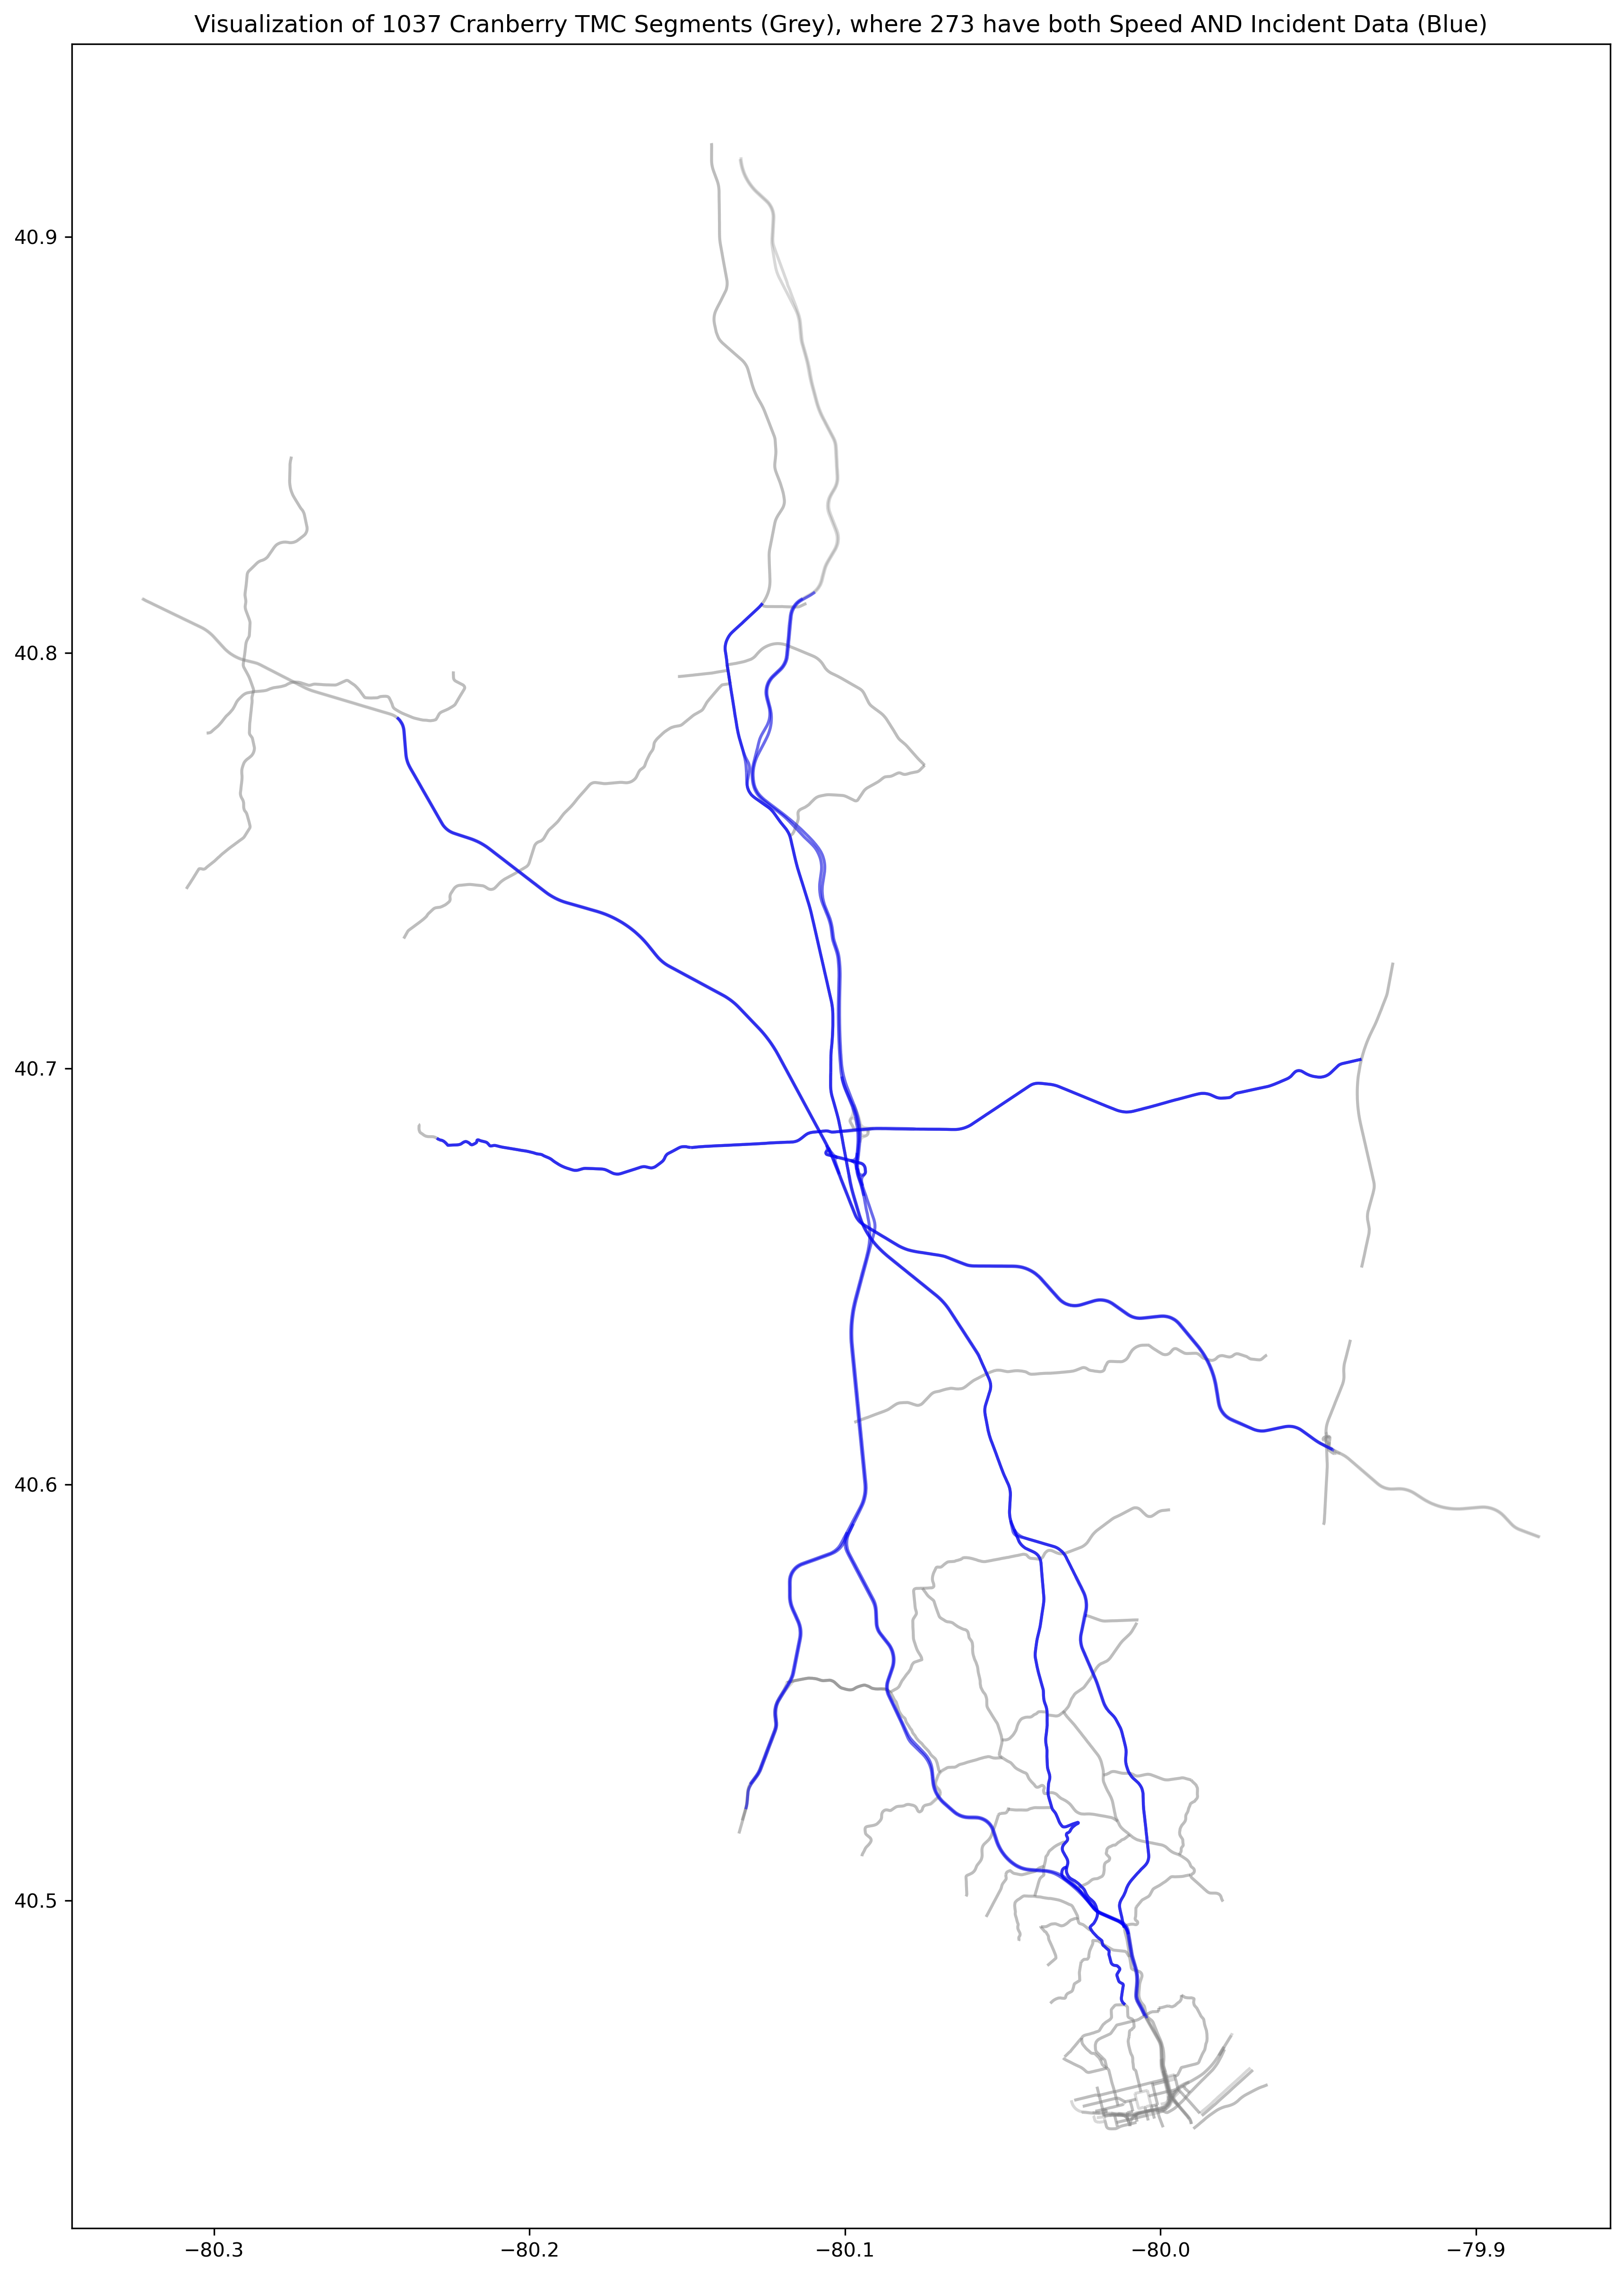

In [8]:
# (1) visualization of 273 cranberry tmc segments covered in speed & incident data
fig, ax = plt.subplots(1,figsize=(30,20), dpi=300)
ax.set_title("Visualization of 1037 Cranberry TMC Segments (Grey), where 273 have both Speed AND Incident Data (Blue)")
gdf_tmc_cranberry.plot(ax=ax, color="grey", alpha=0.3)
# gdf_tmc_cranberry[gdf_tmc_cranberry.tmc.isin(set(set_spd_tmc_segments))].plot(ax=ax, color="blue", alpha=0.5)
gdf_tmc_cranberry[(gdf_tmc_cranberry.tmc.isin(set(set_spd_tmc_segments))) & (gdf_tmc_cranberry.tmc.isin(set(set_inc_segments)))].plot(ax=ax, color="blue", alpha=0.5)
fig.savefig("./viz_tmc_cranberry.jpg")

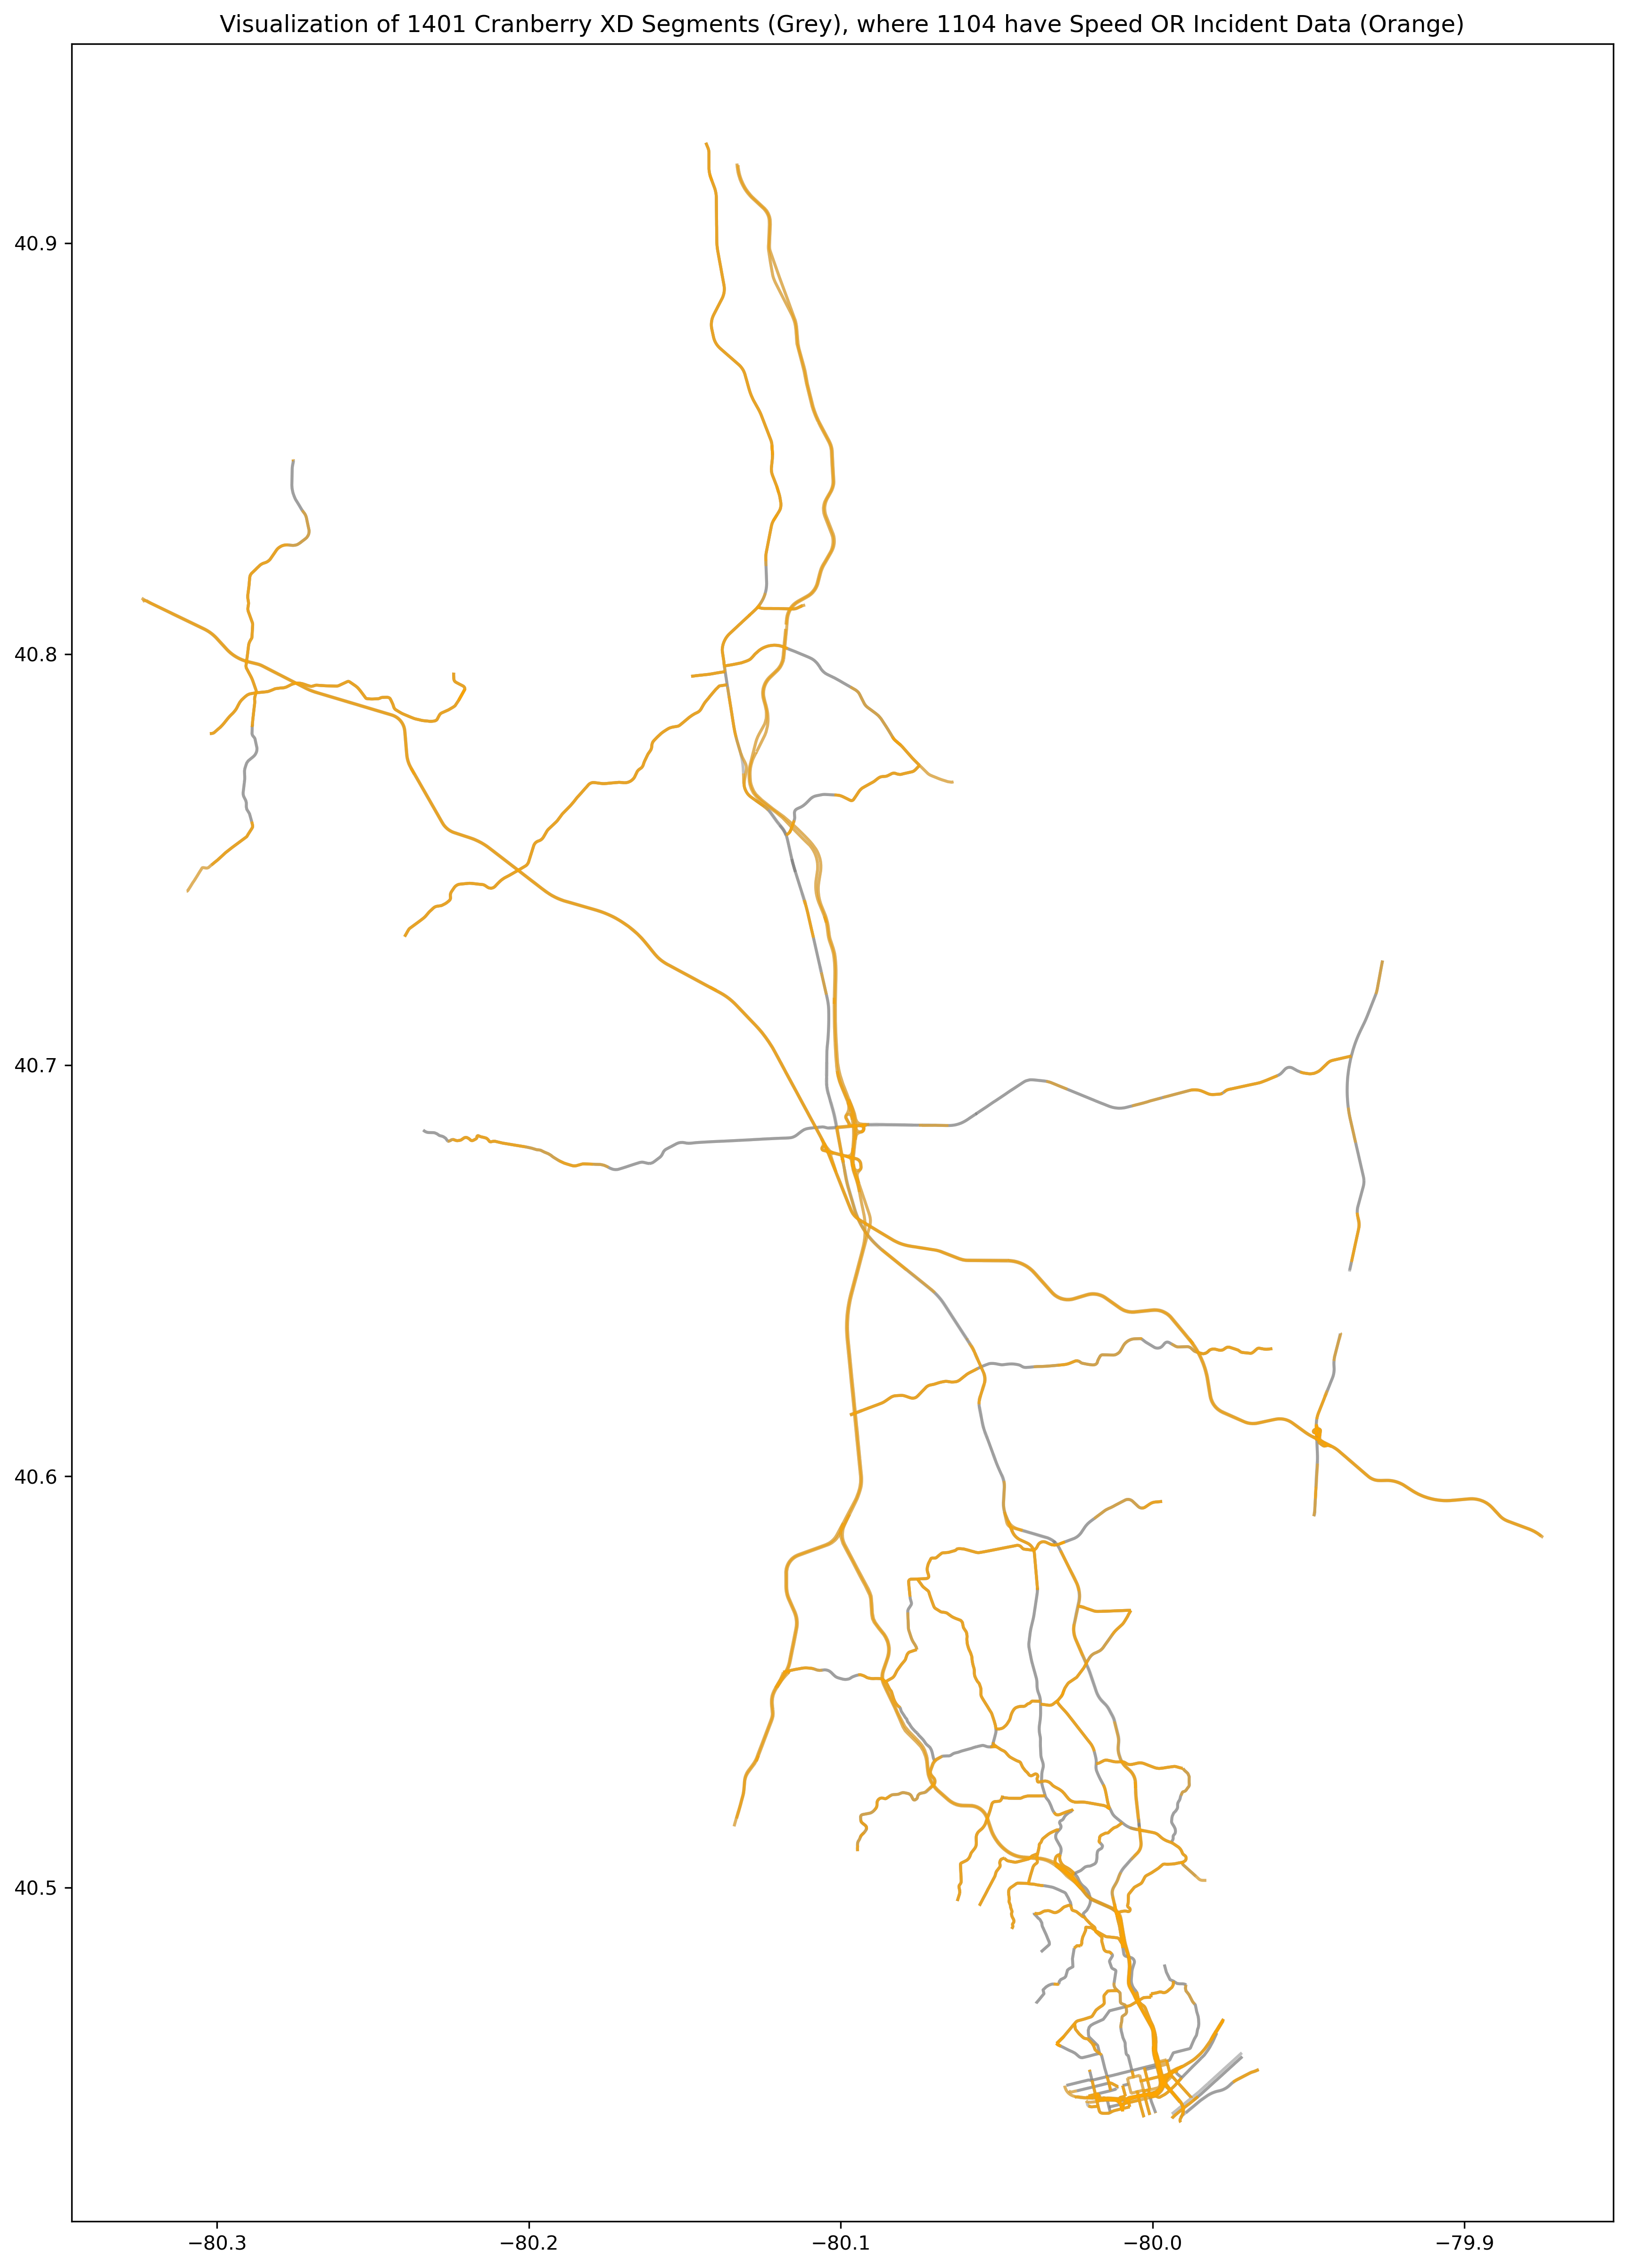

In [9]:
# (2) visualization of 1401 cranberry xd segments 
fig, ax = plt.subplots(1,figsize=(30,20), dpi=300)
ax.set_title("Visualization of 1401 Cranberry XD Segments (Grey), where 1104 have Speed OR Incident Data (Orange)")
gdf_xd_cranberry.plot(ax=ax, color="grey", alpha=0.5)
# gdf_xd_cranberry[(gdf_xd_cranberry.XDSegID.isin(set_spd_xd_segments_str))].plot(ax=ax, color="blue", alpha=0.5)
gdf_xd_cranberry[(gdf_xd_cranberry.XDSegID.isin(set_spd_xd_segments_str)) | (gdf_xd_cranberry.XDSegID.isin(set_inc_segments))].plot(ax=ax, color="Orange", alpha=0.5)
fig.savefig("./viz_xd_cranberry.jpg")

<AxesSubplot: title={'center': 'Visualization of 273 TMC with Speed AND Incident Data (Blue), and 1104 XD with Speed (Orange) OR Incident Data (Red)'}>

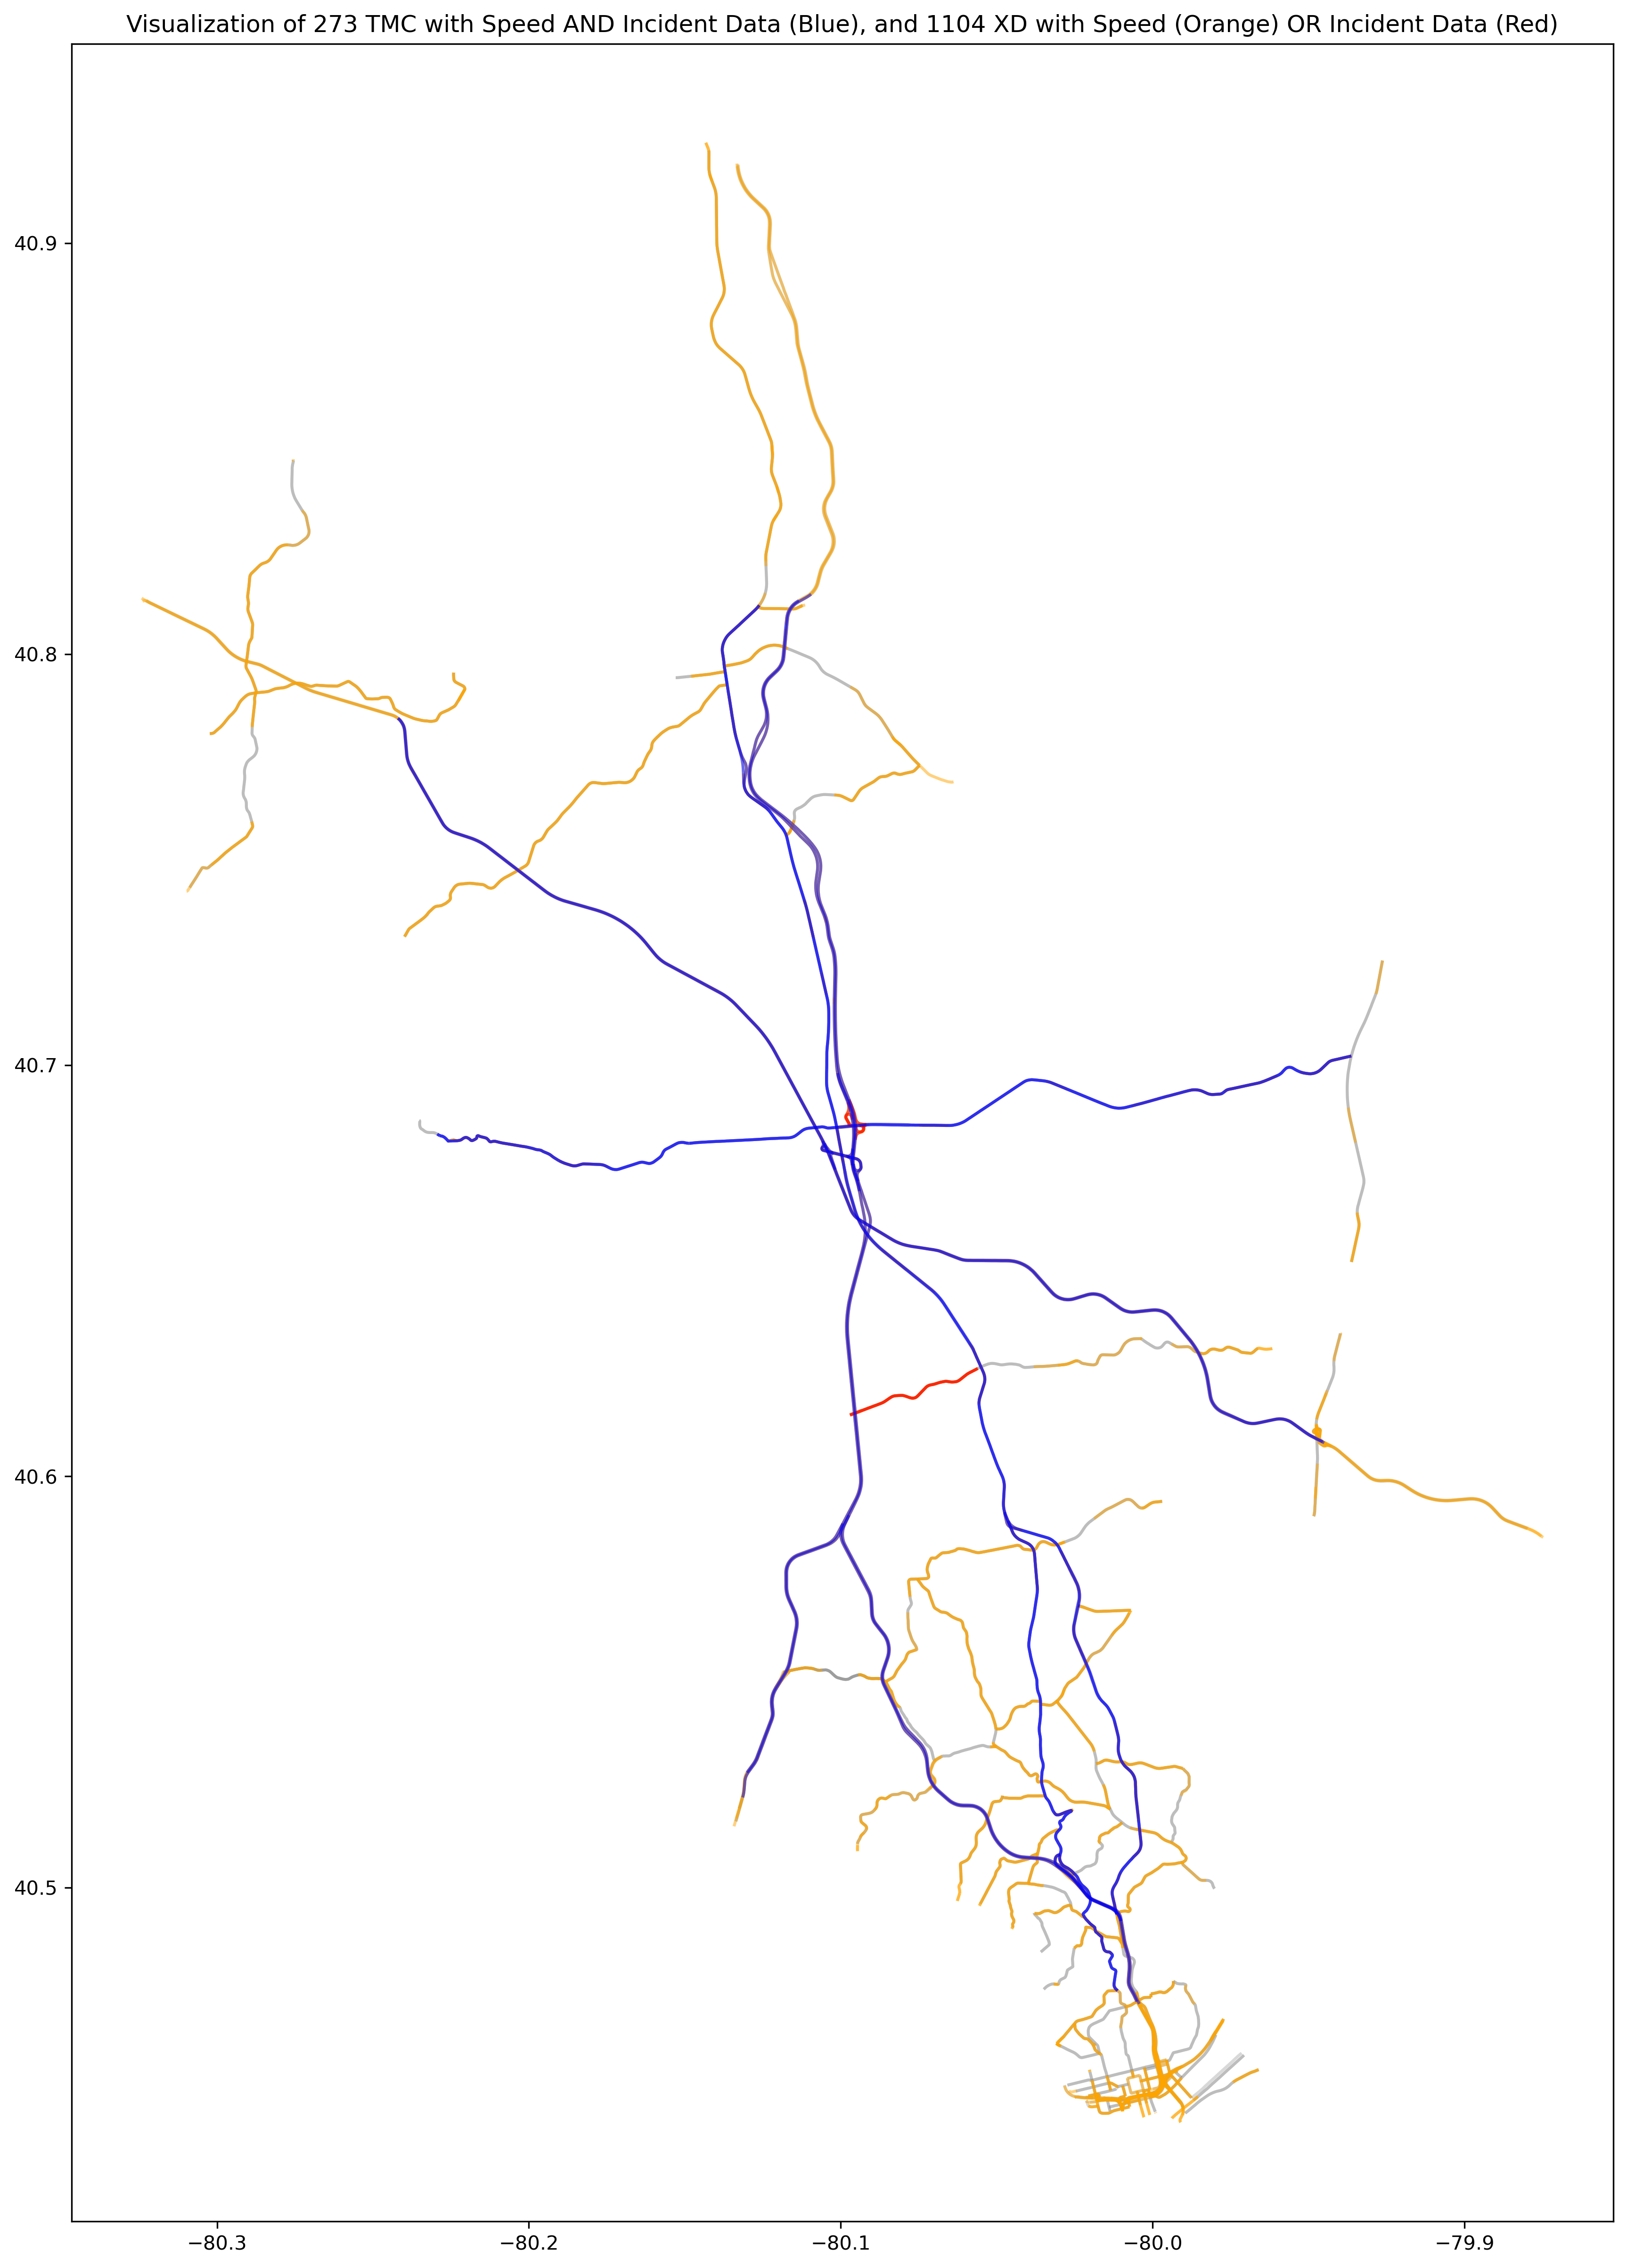

In [10]:
# (3) Visualization of TMC & XD Segments
fig, ax = plt.subplots(1,figsize=(30,20), dpi=300)
ax.set_title("Visualization of 273 TMC with Speed AND Incident Data (Blue), and 1104 XD with Speed (Orange) OR Incident Data (Red)")
gdf_tmc_cranberry.plot(ax=ax, color="grey", alpha=0.3)
gdf_xd_cranberry[(gdf_xd_cranberry.XDSegID.isin(set_spd_xd_segments_str))].plot(ax=ax, color="Orange", alpha=0.5)
gdf_xd_cranberry[(gdf_xd_cranberry.XDSegID.isin(set_inc_segments))].plot(ax=ax, color="Red", alpha=0.5)
gdf_tmc_cranberry[(gdf_tmc_cranberry.tmc.isin(set(set_spd_tmc_segments))) & (gdf_tmc_cranberry.tmc.isin(set(set_inc_segments)))].plot(ax=ax, color="Blue", alpha=0.5)

# 2. Match TMC and XD Segments

### 2.1 Create Buffer for Segments
Since the geometry of TMC segments and those of XD segments may not be perfectly aligned with one another, i.e. there may well be a tiny gap/shift between a TMC-XD pair even though they are supposed to be matched, here a buffer is created for each segment. The size of buffer ("distance" as specified in syntax of geopandas function) is manually defined. 

In [11]:
gdf_tmc_cranberry_polygon = gdf_tmc_cranberry.copy()
gdf_tmc_cranberry_polygon["geometry"] = gdf_tmc_cranberry.to_crs(epsg=3857).buffer(distance=10, resolution=1).to_crs(epsg=4326)

gdf_xd_cranberry_polygon = gdf_xd_cranberry.copy()
gdf_xd_cranberry_polygon["geometry"] = gdf_xd_cranberry.to_crs(epsg=3857).buffer(distance=10, resolution=1).to_crs(epsg=4326)

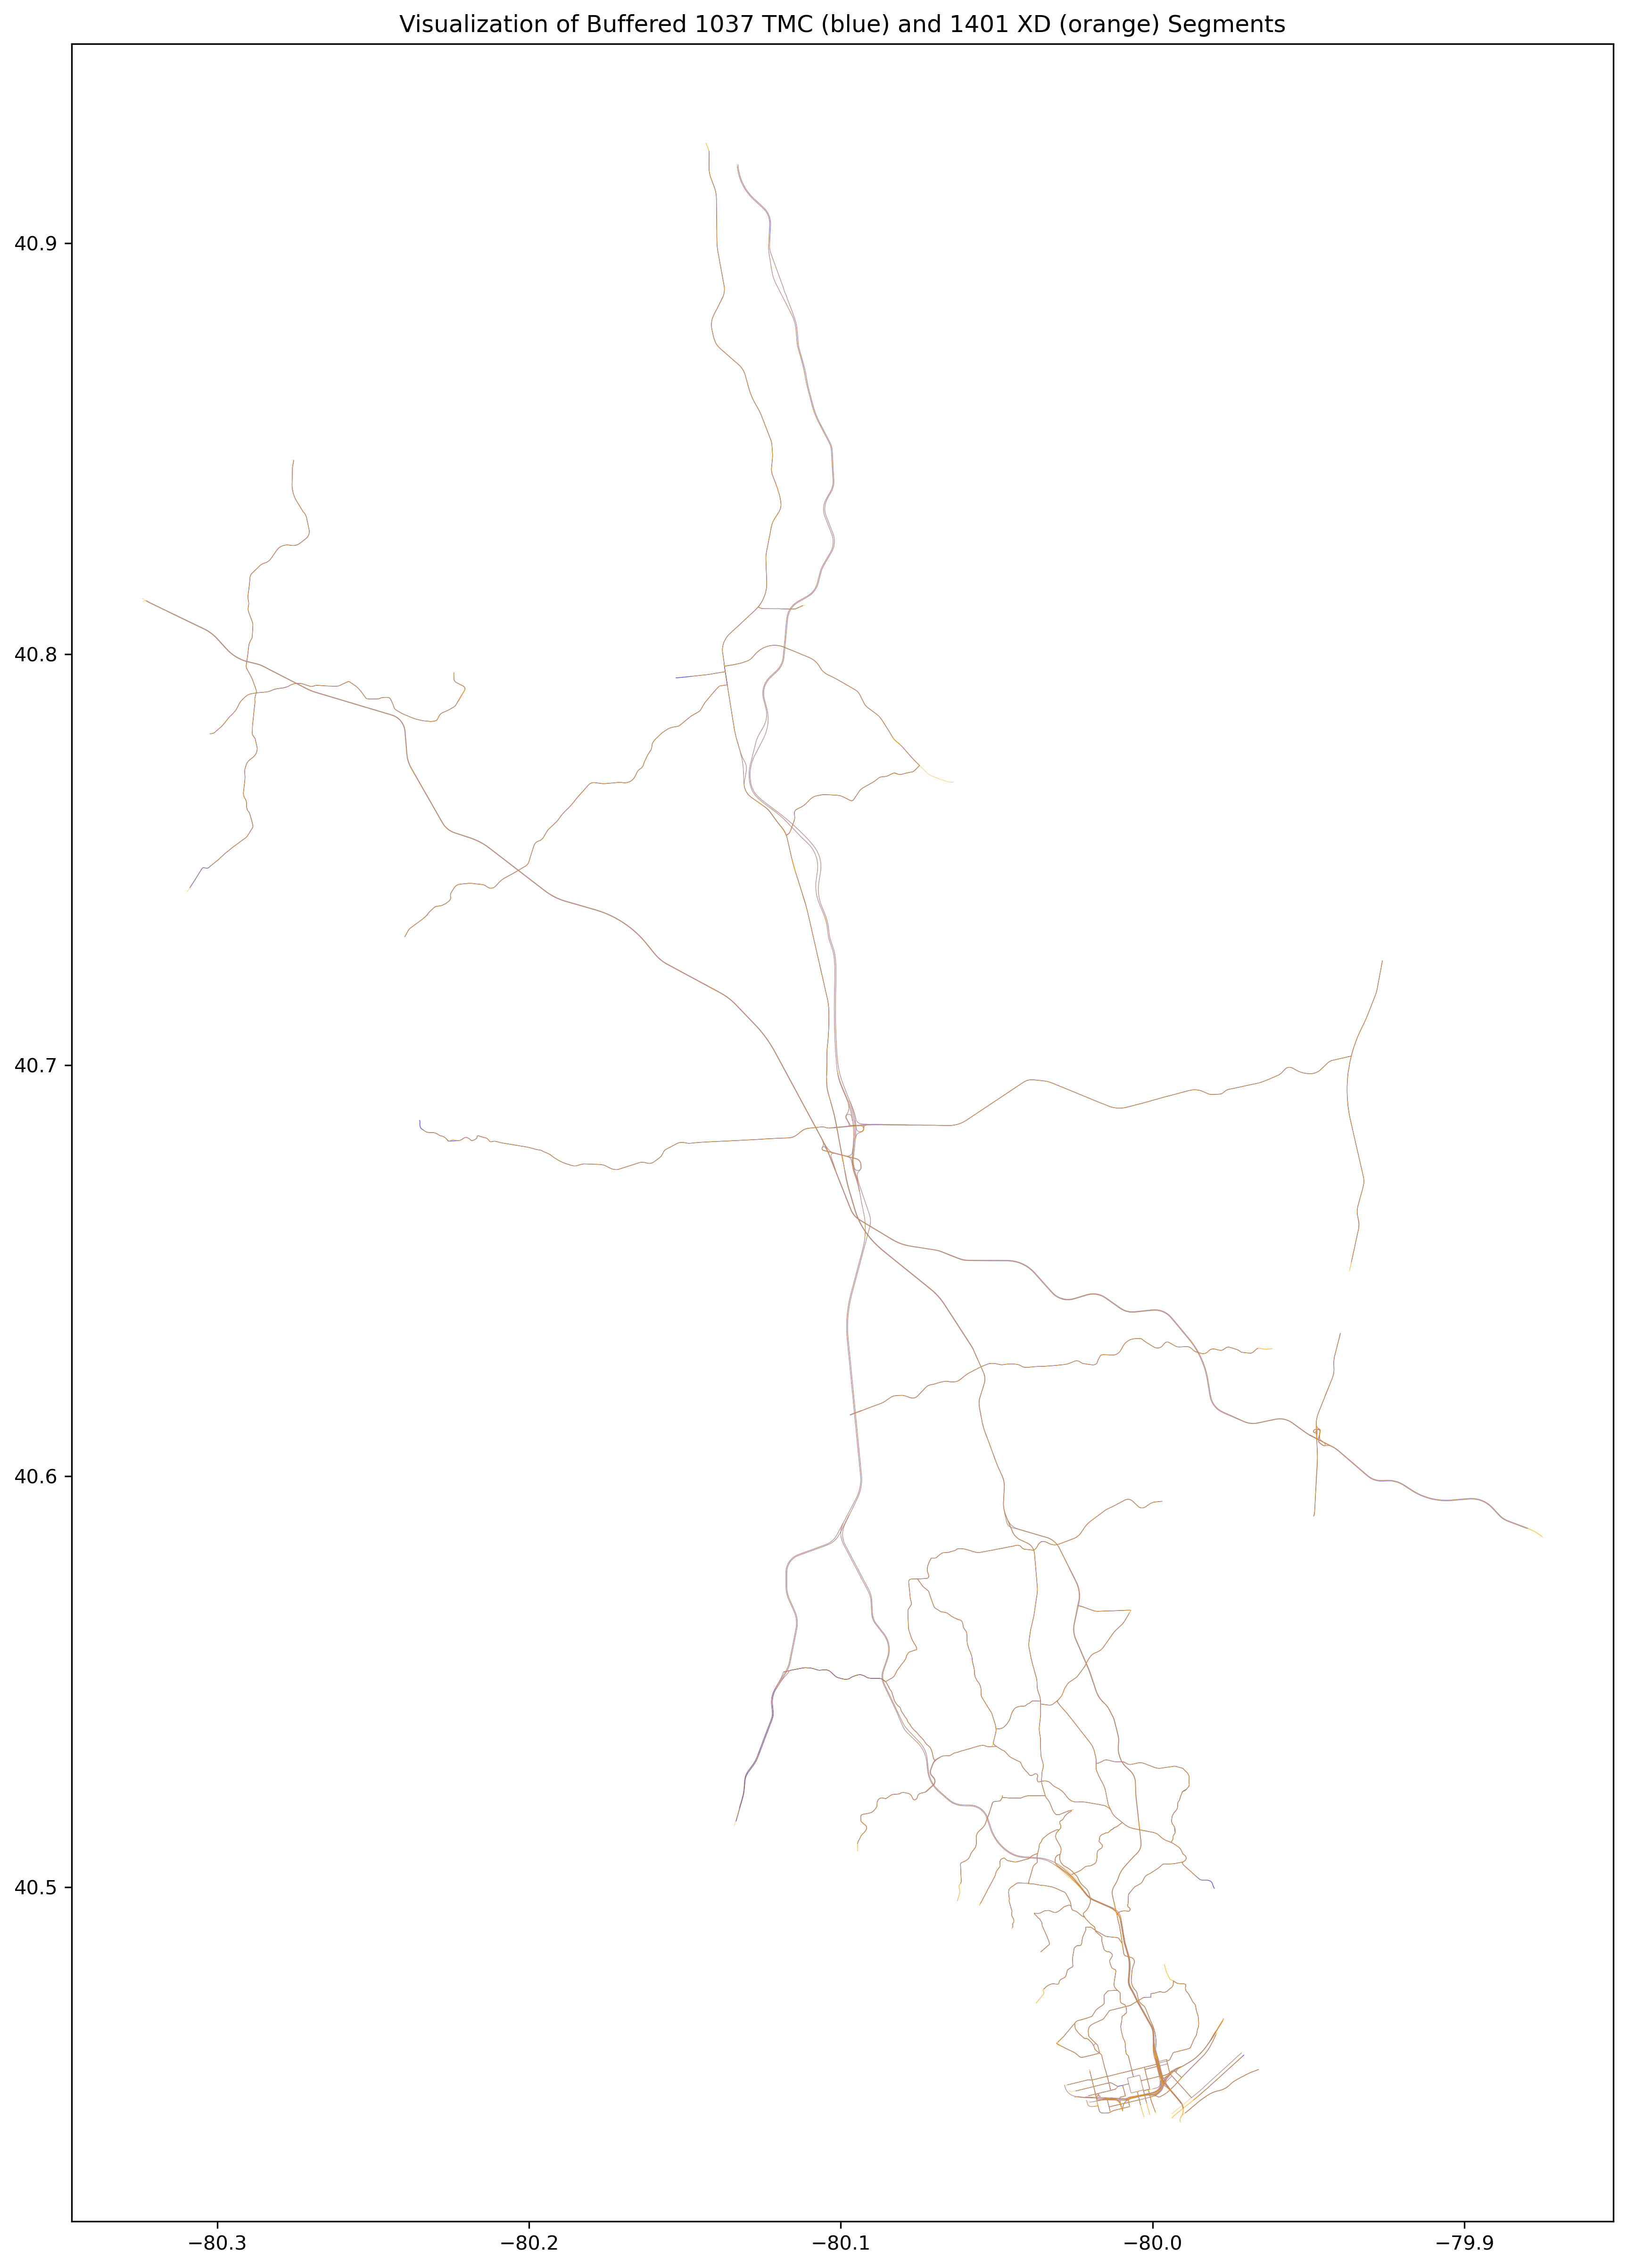

In [12]:
# Visualization of Buffered 1037 TMC (blue) and 1401 XD (yellow) Segments
fig, ax = plt.subplots(1,figsize=(30,20), dpi=300)
ax.set_title("Visualization of Buffered 1037 TMC (blue) and 1401 XD (orange) Segments")
gdf_tmc_cranberry_polygon.plot(ax=ax, color="blue", alpha=0.5)
gdf_xd_cranberry_polygon.plot(ax=ax, color="orange", alpha=0.5)
fig.savefig("./viz_buffered_tmc1037_xd.jpg")

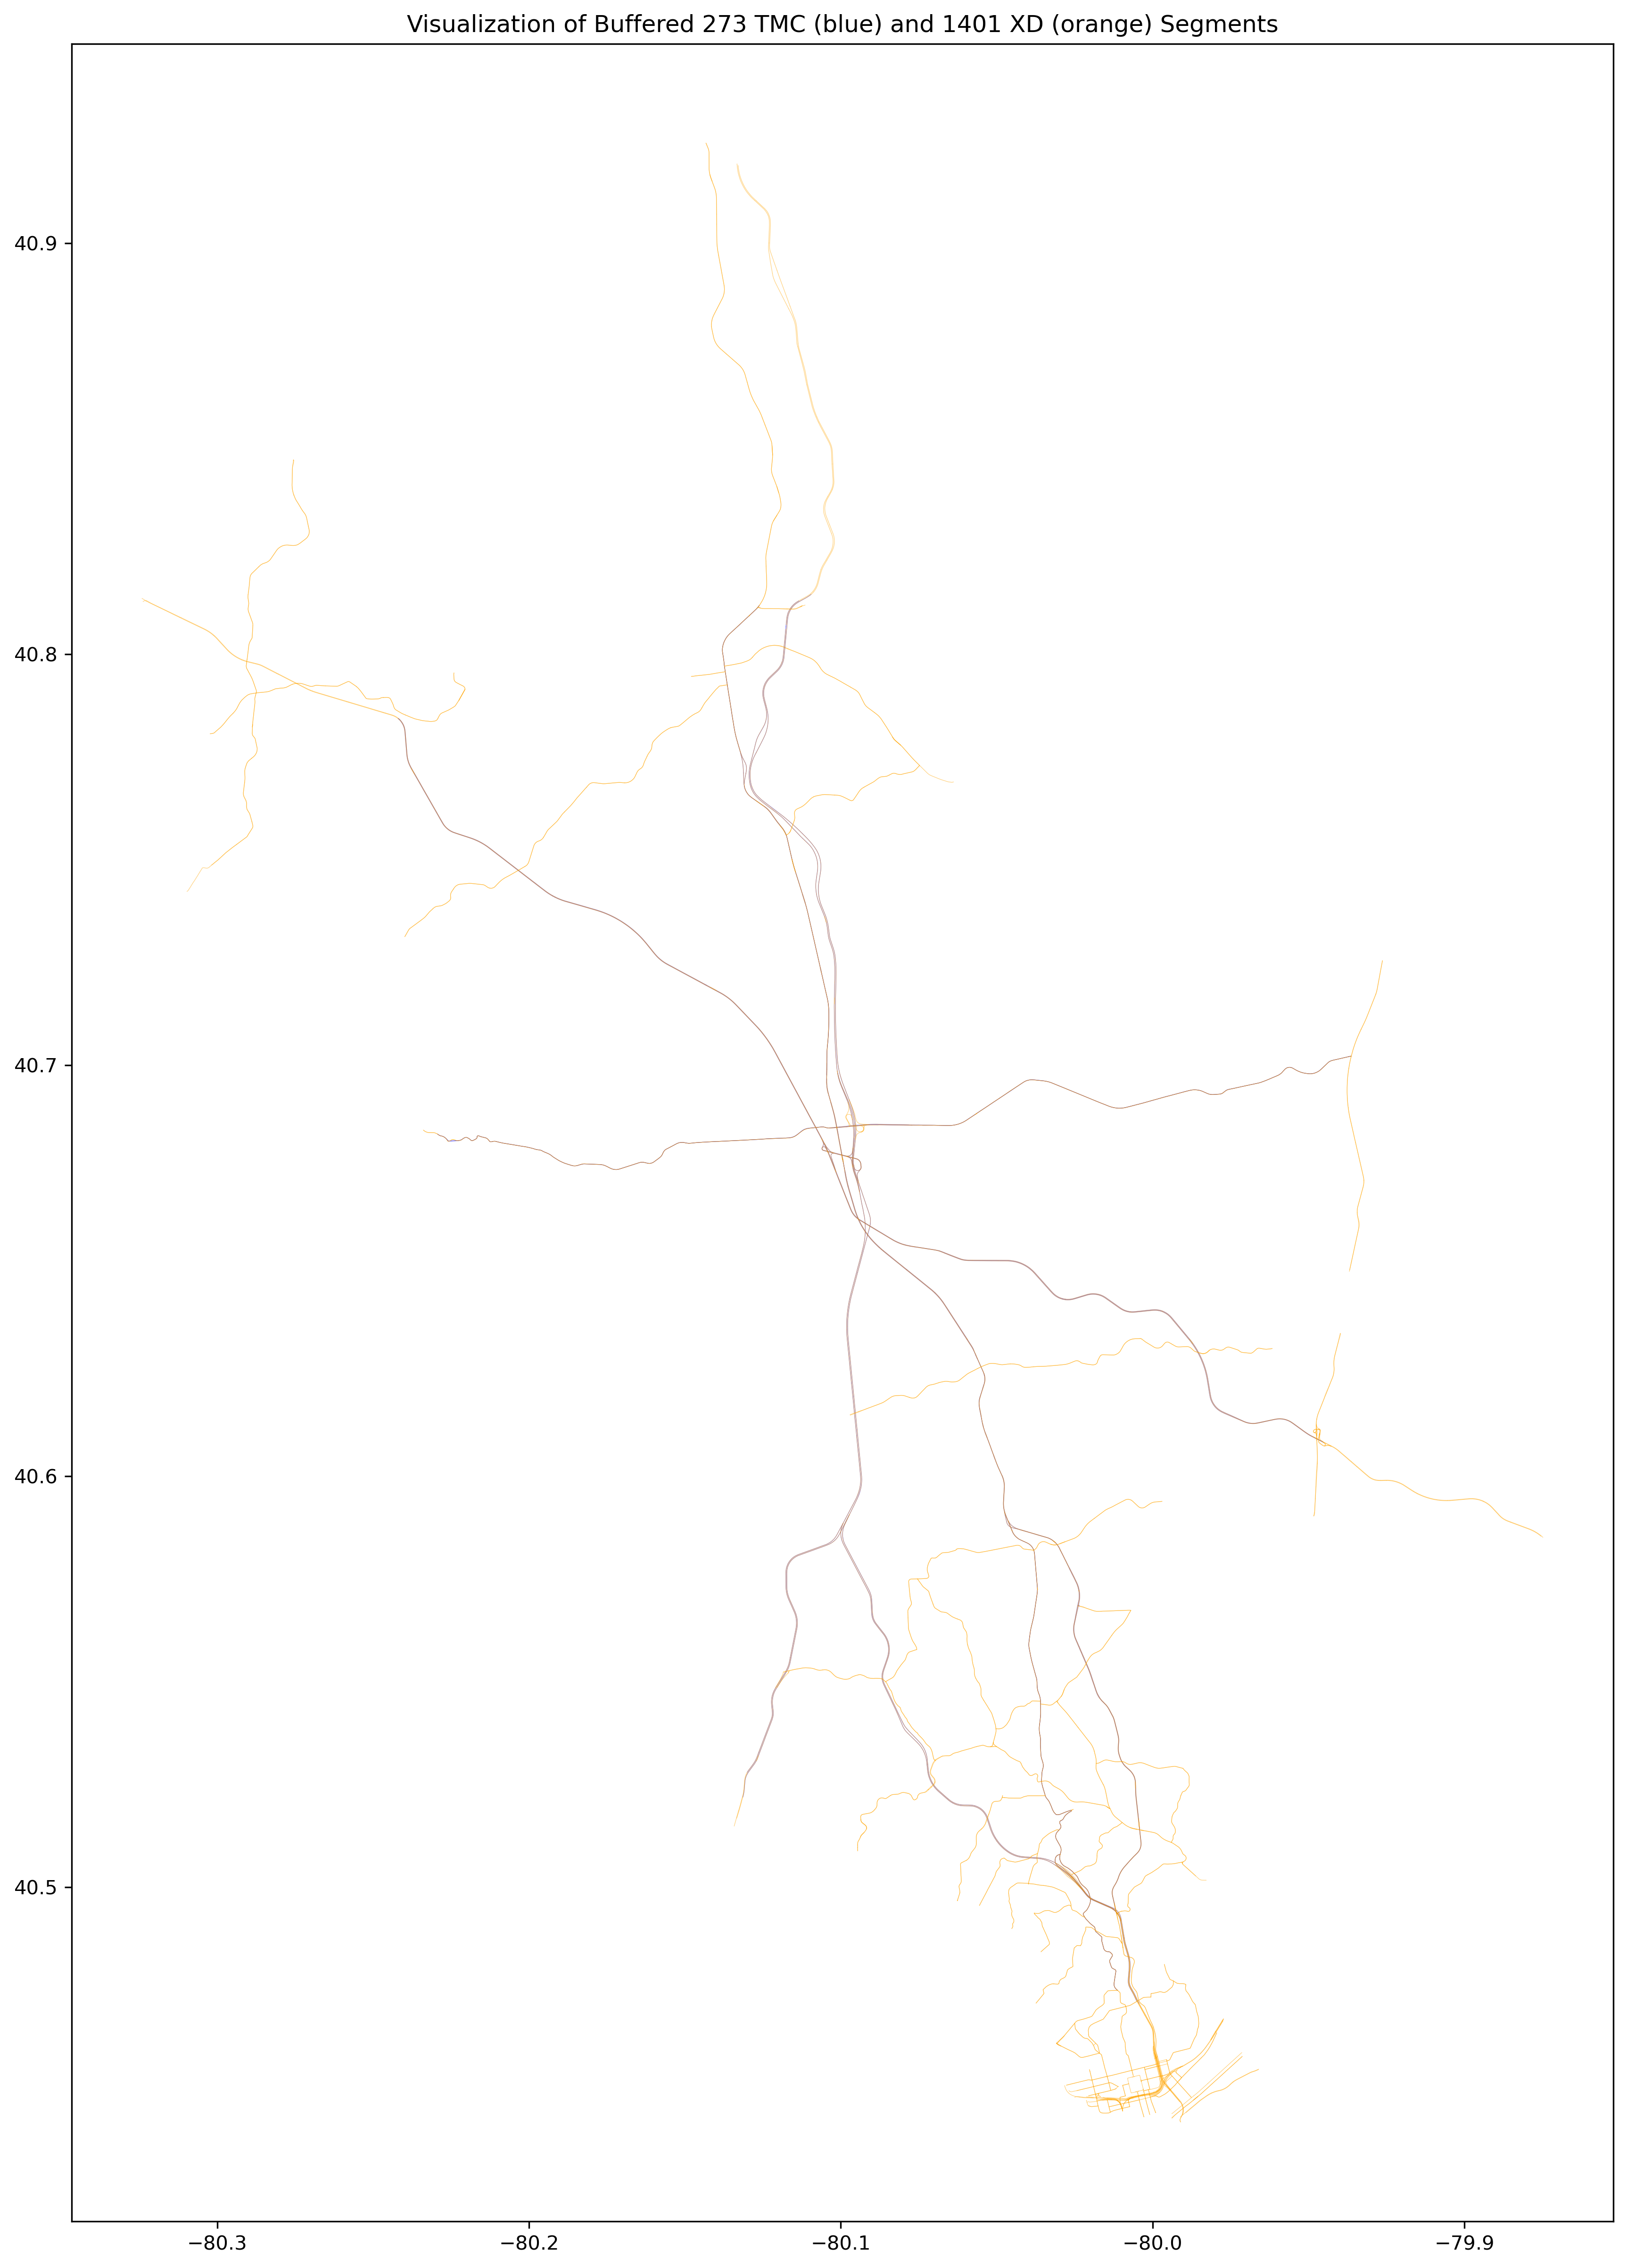

In [13]:
# Visualization of Buffered 273 TMC (blue) and 1401 XD (yellow) Segments
fig, ax = plt.subplots(1,figsize=(30,20), dpi=300)
ax.set_title("Visualization of Buffered 273 TMC (blue) and 1401 XD (orange) Segments")
gdf_tmc_cranberry_polygon[(gdf_tmc_cranberry_polygon.tmc.isin(set_spd_tmc_segments)) & (gdf_tmc_cranberry_polygon.tmc.isin(set_inc_segments))].plot(ax=ax, color="blue", alpha=0.5)
gdf_xd_cranberry_polygon.plot(ax=ax, color="orange", alpha=0.5)
fig.savefig("./viz_buffered_tmc273_xd.jpg")

### 2.2 Spatial Join

In [14]:
# we would like to retain all tmc segments, therefore we do left join here
xd_to_tmc = gpd.sjoin(left_df=gdf_tmc_cranberry_polygon, right_df=gdf_xd_cranberry, how="left", op="intersects") # include all 1037 tmc ids, 1390 xd ids, shape (7167, 41)

In [15]:
'''
'tmc', 'miles', 'direction', 'type_x', 'type_y', 'road_order',
       'roadname', 'roadnumber', 'county', 'state', 'zip', 'start_latitude',
       'start_longitude', 'end_latitude', 'end_longitude', 'geometry',
       'index_right', 'OID', 'XDSegID', 'PreviousXD', 'NextXDSegI', 'FRC',
       'RoadNumber', 'RoadName', 'LinearID', 'Country', 'State', 'County',
       'District', 'Miles', 'Lanes', 'SlipRoad', 'SpecialRoa', 'RoadList',
       'StartLat', 'StartLong', 'EndLat', 'EndLong', 'Bearing', 'XDGroup',
       'ShapeSRID'
'''
xd_to_tmc 

tmc     miles   direction type_x   type_y  road_order  \
0     104N50571  0.021407   WESTBOUND  P1.11  Feature         1.0   
0     104N50571  0.021407   WESTBOUND  P1.11  Feature         1.0   
0     104N50571  0.021407   WESTBOUND  P1.11  Feature         1.0   
0     104N50571  0.021407   WESTBOUND  P1.11  Feature         1.0   
0     104N50571  0.021407   WESTBOUND  P1.11  Feature         1.0   
...         ...       ...         ...    ...      ...         ...   
1036  104+06685  8.115955  NORTHBOUND  P1.11  Feature       734.0   
1036  104+06685  8.115955  NORTHBOUND  P1.11  Feature       734.0   
1036  104+06685  8.115955  NORTHBOUND  P1.11  Feature       734.0   
1036  104+06685  8.115955  NORTHBOUND  P1.11  Feature       734.0   
1036  104+06685  8.115955  NORTHBOUND  P1.11  Feature       734.0   

          roadname roadnumber     county state  ... SlipRoad  SpecialRoa  \
0     STOCKTON AVE       None  ALLEGHENY    PA  ...        0        None   
0     STOCKTON AVE       None  ALLEGHENY    PA  ...        0        None   
0     STOCKTON AVE       None  ALLEGHENY    PA  ...        0        None   
0     STOCKTON AVE       None  ALLEGHENY    PA  ...        0        None   
0     STOCKTON AVE       None  ALLEGHENY    PA  ...        0        None   
...            ...        ...        ...   ...  ...      ...         ...   
1036     PERRY HWY      US-19     BUTLER    PA  ...        0        None   
1036     PERRY HWY      US-19     BUTLER    PA  ...        0        None   
1036     PERRY HWY      US-19     BUTLER    PA  ...        0        None   
1036     PERRY HWY      US-19     BUTLER    PA  ...        0        None   
1036     PERRY HWY      US-19     BUTLER    PA  ...        0        None   

                RoadList  StartLat  StartLong    EndLat    EndLong Bearing  \
0           Cedar Avenue  40.45091   -80.0009  40.45331  -80.00169       N   
0           Cedar Avenue  40.45331  -80.00169  40.45091   -80.0009       S   
0        Anderson Street  40.44967  -80.00098  40.45078  -80.00133       N   
0        Anderson Street  40.45078  -80.00133  40.44967  -80.00098       S   
0        Stockton Avenue  40.45078  -80.00133  40.45051  -80.00286       W   
...                  ...       ...        ...       ...        ...     ...   
1036               US 19  40.89703  -80.13919  40.90708  -80.13984       N   
1036               US 19  40.91514  -80.14131  40.90462  -80.13981       S   
1036               US 19  40.90708  -80.13984  40.91668  -80.14198       N   
1036  US 19,US 19;PA 488  40.91514  -80.14131  40.92439  -80.14326       N   
1036  US 19;PA 488,US 19  40.92439  -80.14326  40.91514  -80.14131       S   

     XDGroup ShapeSRID  
0     501904      4326  
0     455287      4326  
0     511303      4326  
0     447724      4326  
0     471001      4326  
...      ...       ...  
1036  474329      4326  
1036  531444      4326  
1036  474329      4326  
1036  474329      4326  
1036  531444      4326  

[7167 rows x 41 columns]

In [16]:
selected_xd_to_tmc = xd_to_tmc[["tmc", "XDSegID", "PreviousXD", "NextXDSegI", 'StartLat', 'StartLong', 'EndLat', 'EndLong', 'start_latitude', 'start_longitude', 'end_latitude', 'end_longitude', "direction", 'Bearing']]
selected_xd_to_tmc = selected_xd_to_tmc[(selected_xd_to_tmc.tmc.isin(set_spd_tmc_segments)) & (selected_xd_to_tmc.tmc.isin(set_inc_segments))]
selected_xd_to_tmc.columns = ["id_tmc", "id_xd", "prev_xd", "next_xd", 'xd_start_lat', 'xd_start_long', 'xd_end_lat', 'xd_end_long', 'tmc_start_lat', 'tmc_start_long', 'tmc_end_lat', 'tmc_end_long', "direction_tmc", "direction_xd"]

In [17]:
selected_xd_to_tmc # 273 tmc ids, 591 xd ids, shape(1685, 14) 

id_tmc       id_xd     prev_xd     next_xd xd_start_lat  \
9     104N04533  1310356618        None  1310356538     40.58864   
9     104N04533  1310477663  1310477673  1310596881     40.58414   
9     104N04533  1310270745  1310545474  1310270777     40.58864   
11    104N04637  1310472309        None        None     40.50196   
11    104N04637  1310472320        None  1310331653     40.50798   
...         ...         ...         ...         ...          ...   
1035  104P06684  1310593775  1310540321  1310593848      40.8122   
1035  104P06684  1310601715        None        None     40.81116   
1035  104P06684   389255245  1310593764  1310540308     40.80785   
1035  104P06684   429090804        None        None     40.81154   
1035  104P06684   429090805        None        None     40.81126   

     xd_start_long xd_end_lat xd_end_long  tmc_start_lat  tmc_start_long  \
9         -80.0992   40.58094    -80.0974       40.58853       -80.09930   
9        -80.10232   40.59075   -80.09717       40.58853       -80.09930   
9         -80.0992   40.58291   -80.10652       40.58853       -80.09930   
11       -80.02524   40.50798   -80.02963       40.50798       -80.02965   
11       -80.02963   40.50196   -80.02524       40.50798       -80.02965   
...            ...        ...         ...            ...             ...   
1035     -80.12585   40.80669   -80.13321       40.81121       -80.12685   
1035     -80.12694   40.81126   -80.12587       40.81121       -80.12685   
1035     -80.13158   40.81485    -80.1242       40.81121       -80.12685   
1035     -80.12652   40.81126   -80.12587       40.81121       -80.12685   
1035     -80.12587   40.81154   -80.12652       40.81121       -80.12685   

      tmc_end_lat  tmc_end_long direction_tmc direction_xd  
9        40.58508     -80.09988    SOUTHBOUND            S  
9        40.58508     -80.09988    SOUTHBOUND            N  
9        40.58508     -80.09988    SOUTHBOUND            S  
11       40.50594     -80.03116    SOUTHBOUND            N  
11       40.50594     -80.03116    SOUTHBOUND            S  
...           ...           ...           ...          ...  
1035     40.81188     -80.12613    NORTHBOUND            W  
1035     40.81188     -80.12613    NORTHBOUND            E  
1035     40.81188     -80.12613    NORTHBOUND            N  
1035     40.81188     -80.12613    NORTHBOUND            E  
1035     40.81188     -80.12613    NORTHBOUND            W  

[1685 rows x 14 columns]

# 3. Checking on Direction

In [18]:
# compute angles between each spatially joined pair of tmc and xd segments
selected_xd_to_tmc["direction_matchness"] = selected_xd_to_tmc.apply(lambda x: check_direction(x.direction_tmc, x.direction_xd), axis=1)
selected_xd_to_tmc = selected_xd_to_tmc[selected_xd_to_tmc.direction_matchness == 1].reset_index(drop=True) # 273 TMC, 588 xd, shape (1324, 16)
selected_xd_to_tmc["angle"] = selected_xd_to_tmc.apply(lambda x: angle(x.xd_start_lat, x.xd_start_long, x.tmc_start_lat, x.tmc_start_long, x.xd_end_lat, x.xd_end_long, x.tmc_end_lat, x.tmc_end_long), axis=1)

In [19]:
# five number summary of angles between each spatially joined pair of tmc and xd segments
selected_xd_to_tmc["angle"].describe()

count    1.324000e+03
mean     2.451576e-01
std      2.888451e-01
min      4.743187e-09
25%      2.829167e-02
50%      1.005633e-01
75%      4.050240e-01
max      9.997790e-01
Name: angle, dtype: float64

In [20]:
raw_xd_to_tmc_v2 = selected_xd_to_tmc[selected_xd_to_tmc.angle < 0.5] # 273 tmc id, 581 xd ids, shape (1061, 16)

In [21]:
raw_xd_to_tmc_v2.to_csv("./raw_xd_to_tmc_v2.csv", index=False) # need further checking on QGIS (step 4 below)

# 4. Manual Checking on QGIS
- This step involves manual checking and comparison, and is completed on QGIS
- The final tmc-xd matching result has been saved in "../../data/xd_to_tmc_v2.xlsx" and "../../data/xd_to_tmc_v2.csv"

In [23]:
raw_xd_to_tmc_v1 = pd.read_csv("./old/raw_xd_to_tmc_v1.csv") # in version 1, we have already checked 774 candidate pairs 

In [24]:
raw_xd_to_tmc_v1

id_tmc       id_xd       prev_xd       next_xd  xd_start_lat  \
0    104P06676  1310597366  4.290908e+08           NaN      40.68480   
1    104P06676  1310597509  4.291102e+08  1.310324e+09      40.68508   
2    104P06676   388051958           NaN           NaN      40.68528   
3    104P06676  1310323857  1.310598e+09  4.290908e+08      40.68528   
4    104P06676   429090769  1.310324e+09  1.310291e+09      40.68540   
..         ...         ...           ...           ...           ...   
769  104+04532  1310380359  1.310330e+09  1.310369e+09      40.52001   
770  104+04532  1310498302           NaN           NaN      40.52134   
771  104+04734  1310319396  1.310321e+09  1.310232e+09      40.57238   
772  104+04734  1310231536  1.310319e+09  1.310307e+09      40.58203   
773  104+04734  1310306645  1.310232e+09  4.290913e+08      40.58681   

     xd_start_long  xd_end_lat  xd_end_long  tmc_start_lat  tmc_start_long  \
0        -80.09259    40.68543    -80.09180       40.68504       -80.09806   
1        -80.09725    40.68528    -80.09392       40.68504       -80.09806   
2        -80.09392    40.68540    -80.09267       40.68504       -80.09806   
3        -80.09392    40.68540    -80.09267       40.68504       -80.09806   
4        -80.09267    40.68543    -80.09180       40.68504       -80.09806   
..             ...         ...          ...            ...             ...   
769      -80.05861    40.52134    -80.06528       40.51985       -80.05697   
770      -80.06528    40.52989    -80.07210       40.51985       -80.05697   
771      -80.03693    40.58203    -80.03812       40.58206       -80.03812   
772      -80.03812    40.58681    -80.04515       40.58206       -80.03812   
773      -80.04504    40.58915    -80.04631       40.58206       -80.03812   

     tmc_end_lat  tmc_end_long     angle  
0       40.68545     -80.09178  0.193533  
1       40.68545     -80.09178  0.001657  
2       40.68545     -80.09178  0.009712  
3       40.68545     -80.09178  0.009712  
4       40.68545     -80.09178  0.009780  
..           ...           ...       ...  
769     40.52160     -80.06568  0.000465  
770     40.52160     -80.06568  0.222564  
771     40.58765     -80.04555  0.255632  
772     40.58765     -80.04555  0.015237  
773     40.58765     -80.04555  0.136409  

[774 rows x 13 columns]

In [25]:
# we need to check another 309 candidate pairs
# 78 TMC matched with 188 XD, shape (309, 16)
raw_xd_to_tmc_v2_difference_v1 = raw_xd_to_tmc_v2[~((raw_xd_to_tmc_v2.id_tmc.isin(set(raw_xd_to_tmc_v1.id_tmc.unique()))) | (raw_xd_to_tmc_v2.id_xd.isin(set(raw_xd_to_tmc_v1.id_xd.unique()))))] 

In [26]:
raw_xd_to_tmc_v2_difference_v1

id_tmc       id_xd     prev_xd     next_xd xd_start_lat  \
2     104N04637  1310472320        None  1310331653     40.50798   
3     104N04637  1310552593  1310417631  1310219452     40.50798   
4     104N04637  1310417631   387933728  1310552593     40.51874   
5     104N04637  1310568071   389256522  1310568084     40.50585   
6     104-04636  1310331653  1310472320   388068933     40.50275   
...         ...         ...         ...         ...          ...   
1317  104+06684  1310601715        None        None     40.81116   
1318  104+06684   389255245  1310593764  1310540308     40.80785   
1320  104P06684  1310601715        None        None     40.81116   
1321  104P06684   389255245  1310593764  1310540308     40.80785   
1322  104P06684   429090804        None        None     40.81154   

     xd_start_long xd_end_lat xd_end_long  tmc_start_lat  tmc_start_long  \
2        -80.02963   40.50196   -80.02524       40.50798       -80.02965   
3        -80.02963    40.5034   -80.02512       40.50798       -80.02965   
4        -80.02609   40.50798   -80.02963       40.50798       -80.02965   
5        -80.03098   40.50745    -80.0414       40.50798       -80.02965   
6        -80.02628   40.50096   -80.02415       40.50594       -80.03116   
...            ...        ...         ...            ...             ...   
1317     -80.12694   40.81126   -80.12587       40.79256       -80.13640   
1318     -80.13158   40.81485    -80.1242       40.79256       -80.13640   
1320     -80.12694   40.81126   -80.12587       40.81121       -80.12685   
1321     -80.13158   40.81485    -80.1242       40.81121       -80.12685   
1322     -80.12652   40.81126   -80.12587       40.81121       -80.12685   

      tmc_end_lat  tmc_end_long direction_tmc direction_xd  \
2        40.50594     -80.03116    SOUTHBOUND            S   
3        40.50594     -80.03116    SOUTHBOUND            S   
4        40.50594     -80.03116    SOUTHBOUND            S   
5        40.50594     -80.03116    SOUTHBOUND            W   
6        40.50278     -80.02624    SOUTHBOUND            S   
...           ...           ...           ...          ...   
1317     40.81121     -80.12685    NORTHBOUND            E   
1318     40.81121     -80.12685    NORTHBOUND            N   
1320     40.81188     -80.12613    NORTHBOUND            E   
1321     40.81188     -80.12613    NORTHBOUND            N   
1322     40.81188     -80.12613    NORTHBOUND            E   

      direction_matchness     angle  
2                    True  0.403387  
3                    True  0.450375  
4                    True  0.101654  
5                    True  0.345672  
6                    True  0.040729  
...                   ...       ...  
1317                 True  0.319697  
1318                 True  0.107769  
1320                 True  0.208893  
1321                 True  0.003035  
1322                 True  0.368027  

[309 rows x 16 columns]

In [27]:
raw_xd_to_tmc_v2_difference_v1.to_csv("./raw_xd_to_tmc_v2_difference_v1.csv", index=False) # need further checking on QGIS

<AxesSubplot: >

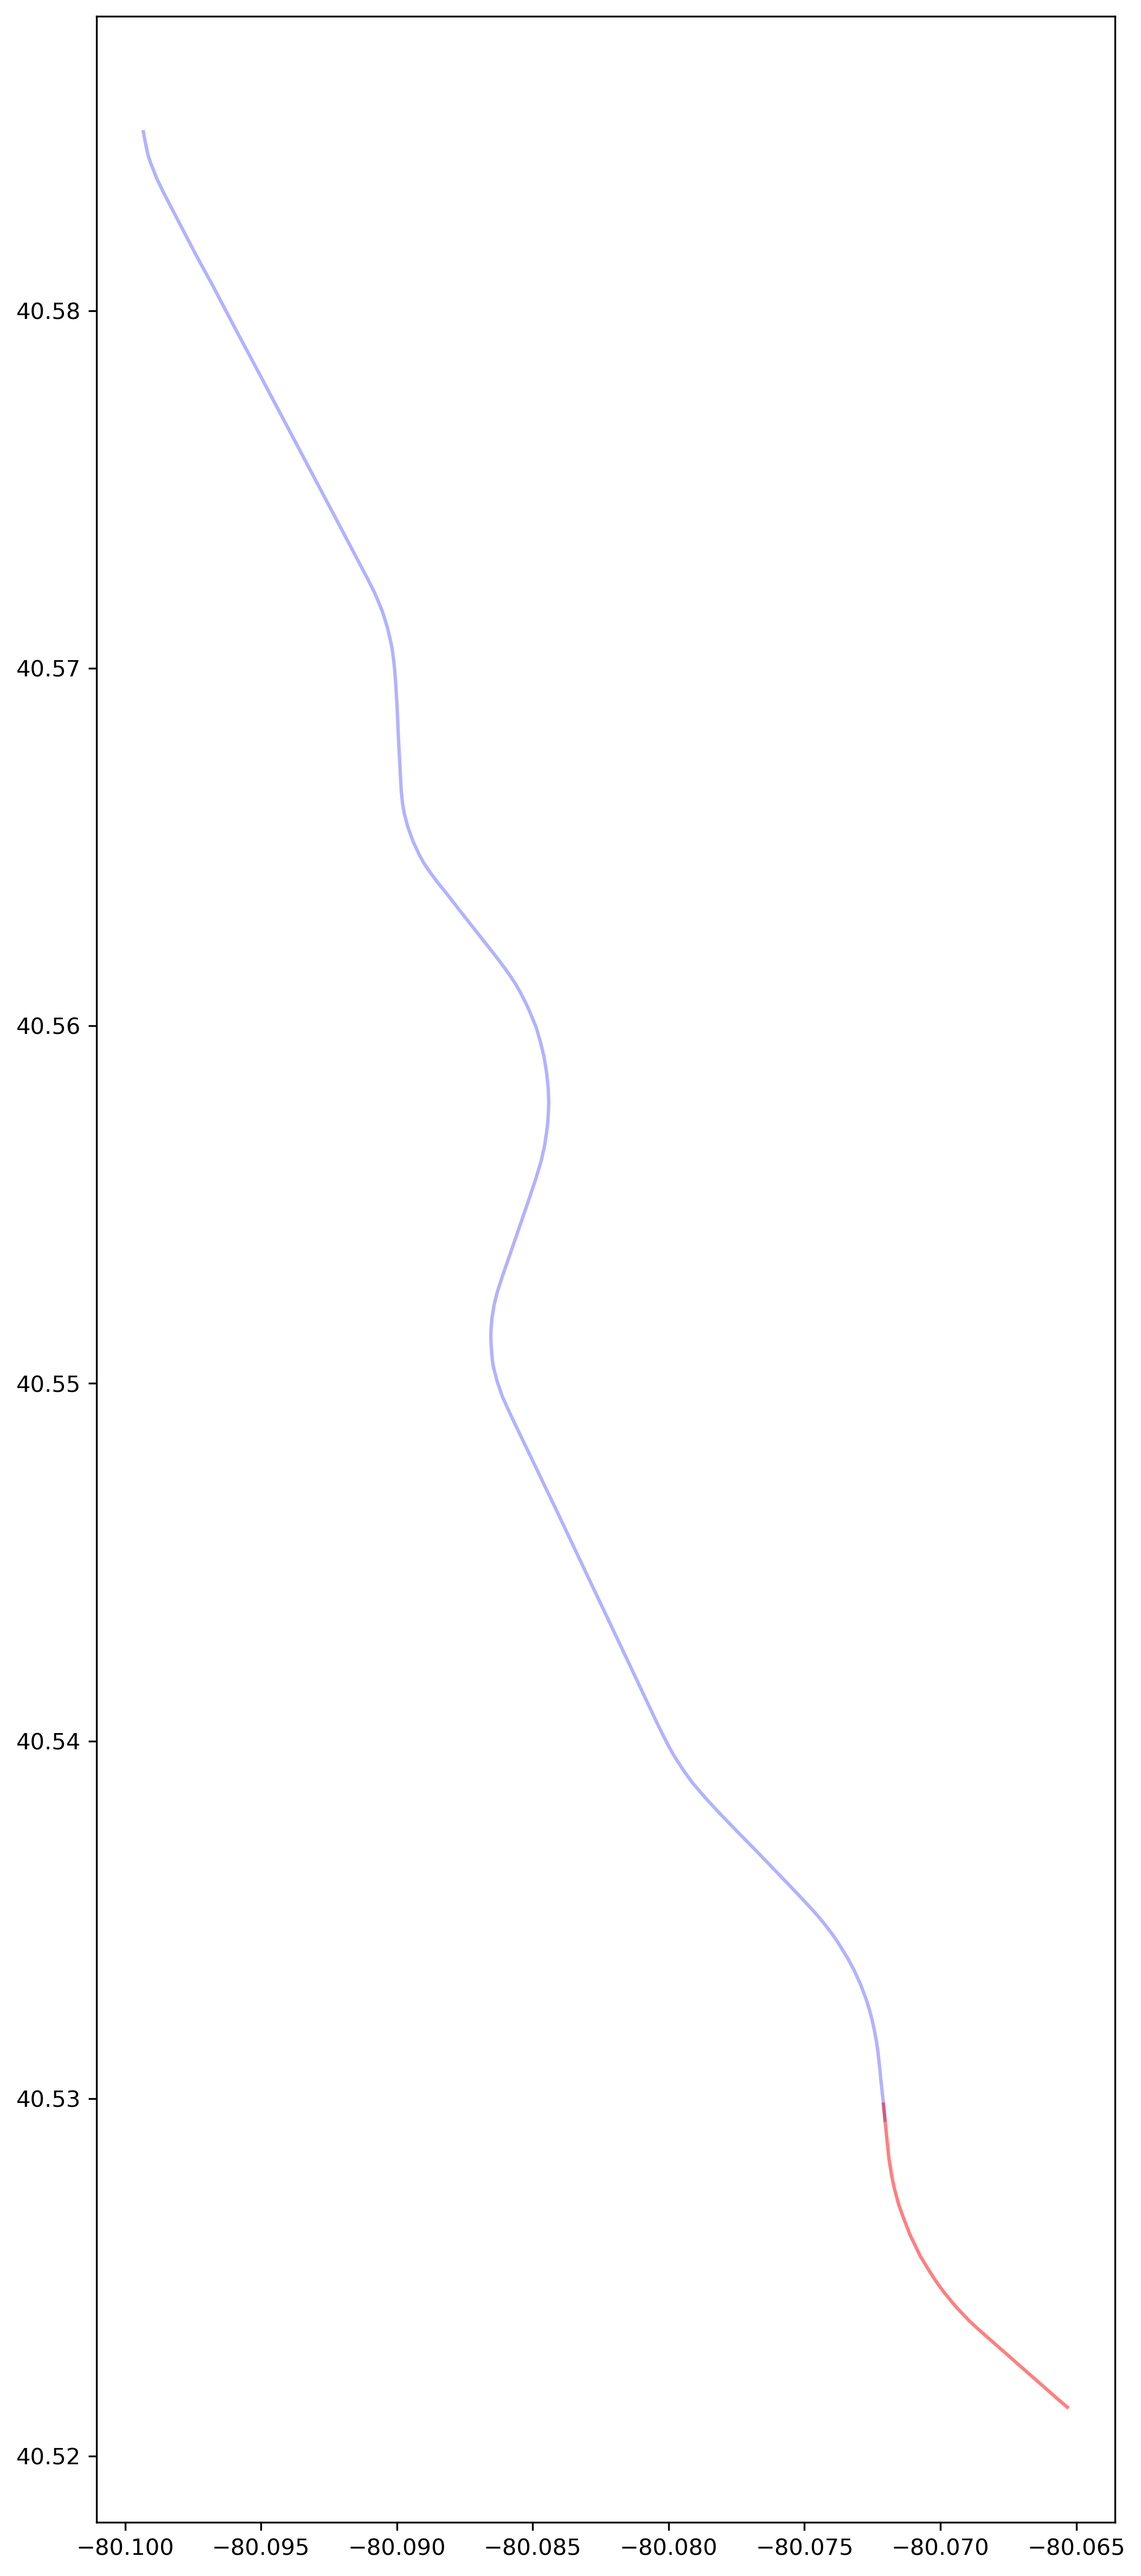

In [102]:
# Visualization for Checking
fig, ax = plt.subplots(1,figsize=(30,20), dpi=300)
curr_tmc = "104+04533"
curr_xd = "1310498302"
# print(f"curr_tmc: {curr_tmc}    direction: {raw_xd_to_tmc_v2_difference_v1[(raw_xd_to_tmc_v2_difference_v1.id_tmc == curr_tmc) & (raw_xd_to_tmc_v2_difference_v1.id_xd == curr_xd)].direction_tmc.values[0]}")
# print(f"curr_xd: {curr_xd}      direction: {raw_xd_to_tmc_v2_difference_v1[(raw_xd_to_tmc_v2_difference_v1.id_tmc == curr_tmc) & (raw_xd_to_tmc_v2_difference_v1.id_xd == curr_xd)].direction_xd.values[0]}")
# gdf_tmc_cranberry.plot(ax=ax, color="grey", alpha=0.1)
gdf_tmc_cranberry[gdf_tmc_cranberry.tmc == curr_tmc].plot(ax=ax, color="Blue", alpha=0.3)
gdf_xd_cranberry[gdf_xd_cranberry.XDSegID == curr_xd].plot(ax=ax, color="Red", alpha=0.5)

# 5. Save Final Result as Dictionary

In [28]:
final_xd_to_tmc = pd.read_csv("./xd_to_tmc_v2.csv")

In [29]:
final_xd_to_tmc # 269 tmc matched with 464 xd, shape (572, 17)

id_tmc       id_xd       prev_xd       next_xd  xd_start_lat  \
0    104-06683   135027391           NaN           NaN      40.80951   
1    104P08677  1310227117           NaN  1.310580e+09      40.67132   
2    104P09016  1310377372  1.310456e+09  1.310377e+09      40.68016   
3    104-09196   387933728  1.310237e+09  1.310418e+09      40.51827   
4    104+09197   388070541  1.310418e+09  1.310237e+09      40.51874   
..         ...         ...           ...           ...           ...   
567  104P06676   388051958           NaN           NaN      40.68528   
568  104P06676  1310323857  1.310598e+09  4.290908e+08      40.68528   
569  104P06676   429090769  1.310324e+09  1.310291e+09      40.68540   
570  104P06676   429110245  1.344530e+08  1.310598e+09      40.68500   
571  104P11466  1310308164  1.310393e+09  1.310573e+09      40.67132   

     xd_start_long  xd_end_lat  xd_end_long  tmc_start_lat  tmc_start_long  \
0        -80.12922    40.80937    -80.12941       40.81121       -80.12685   
1        -80.09421    40.67797    -80.09850       40.67791       -80.09825   
2        -80.15456    40.68148    -80.13932       40.68102       -80.14885   
3        -80.03164    40.51874    -80.02609       40.51824       -80.03161   
4        -80.02609    40.51827    -80.03164       40.50798       -80.02965   
..             ...         ...          ...            ...             ...   
567      -80.09392    40.68540    -80.09267       40.68504       -80.09806   
568      -80.09392    40.68540    -80.09267       40.68504       -80.09806   
569      -80.09267    40.68543    -80.09180       40.68504       -80.09806   
570      -80.09809    40.68508    -80.09725       40.68504       -80.09806   
571      -80.09421    40.67590    -80.09592       40.67183       -80.09442   

     tmc_end_lat  tmc_end_long direction_tmc direction_xd direction_matchness  \
0       40.79256     -80.13640    SOUTHBOUND            W                True   
1       40.67798     -80.09854     WESTBOUND            N                True   
2       40.68102     -80.14863     EASTBOUND            E                True   
3       40.50798     -80.02965    SOUTHBOUND            E                True   
4       40.51824     -80.03161    NORTHBOUND            W                True   
..           ...           ...           ...          ...                 ...   
567     40.68545     -80.09178           NaN          NaN                 NaN   
568     40.68545     -80.09178           NaN          NaN                 NaN   
569     40.68545     -80.09178           NaN          NaN                 NaN   
570     40.68545     -80.09178           NaN          NaN                 NaN   
571     40.67599     -80.09595           NaN          NaN                 NaN   

        angle    Note  
0    0.147224    XD很小  
1    0.242239  TMC太小了  
2    0.027502  TMC太小了  
3    0.466808     NaN  
4    0.466808     NaN  
..        ...     ...  
567  0.009712     NaN  
568  0.009712     NaN  
569  0.009780     NaN  
570  0.009472     NaN  
571  0.001560     NaN  

[572 rows x 17 columns]

In [32]:
final_dict_xd_to_tmc = final_xd_to_tmc.groupby("id_tmc").apply(lambda x: x.id_xd.tolist()).to_dict()
final_dict_tmc_to_xd = final_xd_to_tmc.groupby("id_xd").apply(lambda x: x.id_tmc.tolist()).to_dict()

In [33]:
with open("../../data/xd_to_tmc_v2.pkl", "wb") as f1, open("../../data/tmc_to_xd_v2.pkl", "wb") as f2:
    pickle.dump(final_dict_xd_to_tmc, f1)
    pickle.dump(final_dict_tmc_to_xd, f2)

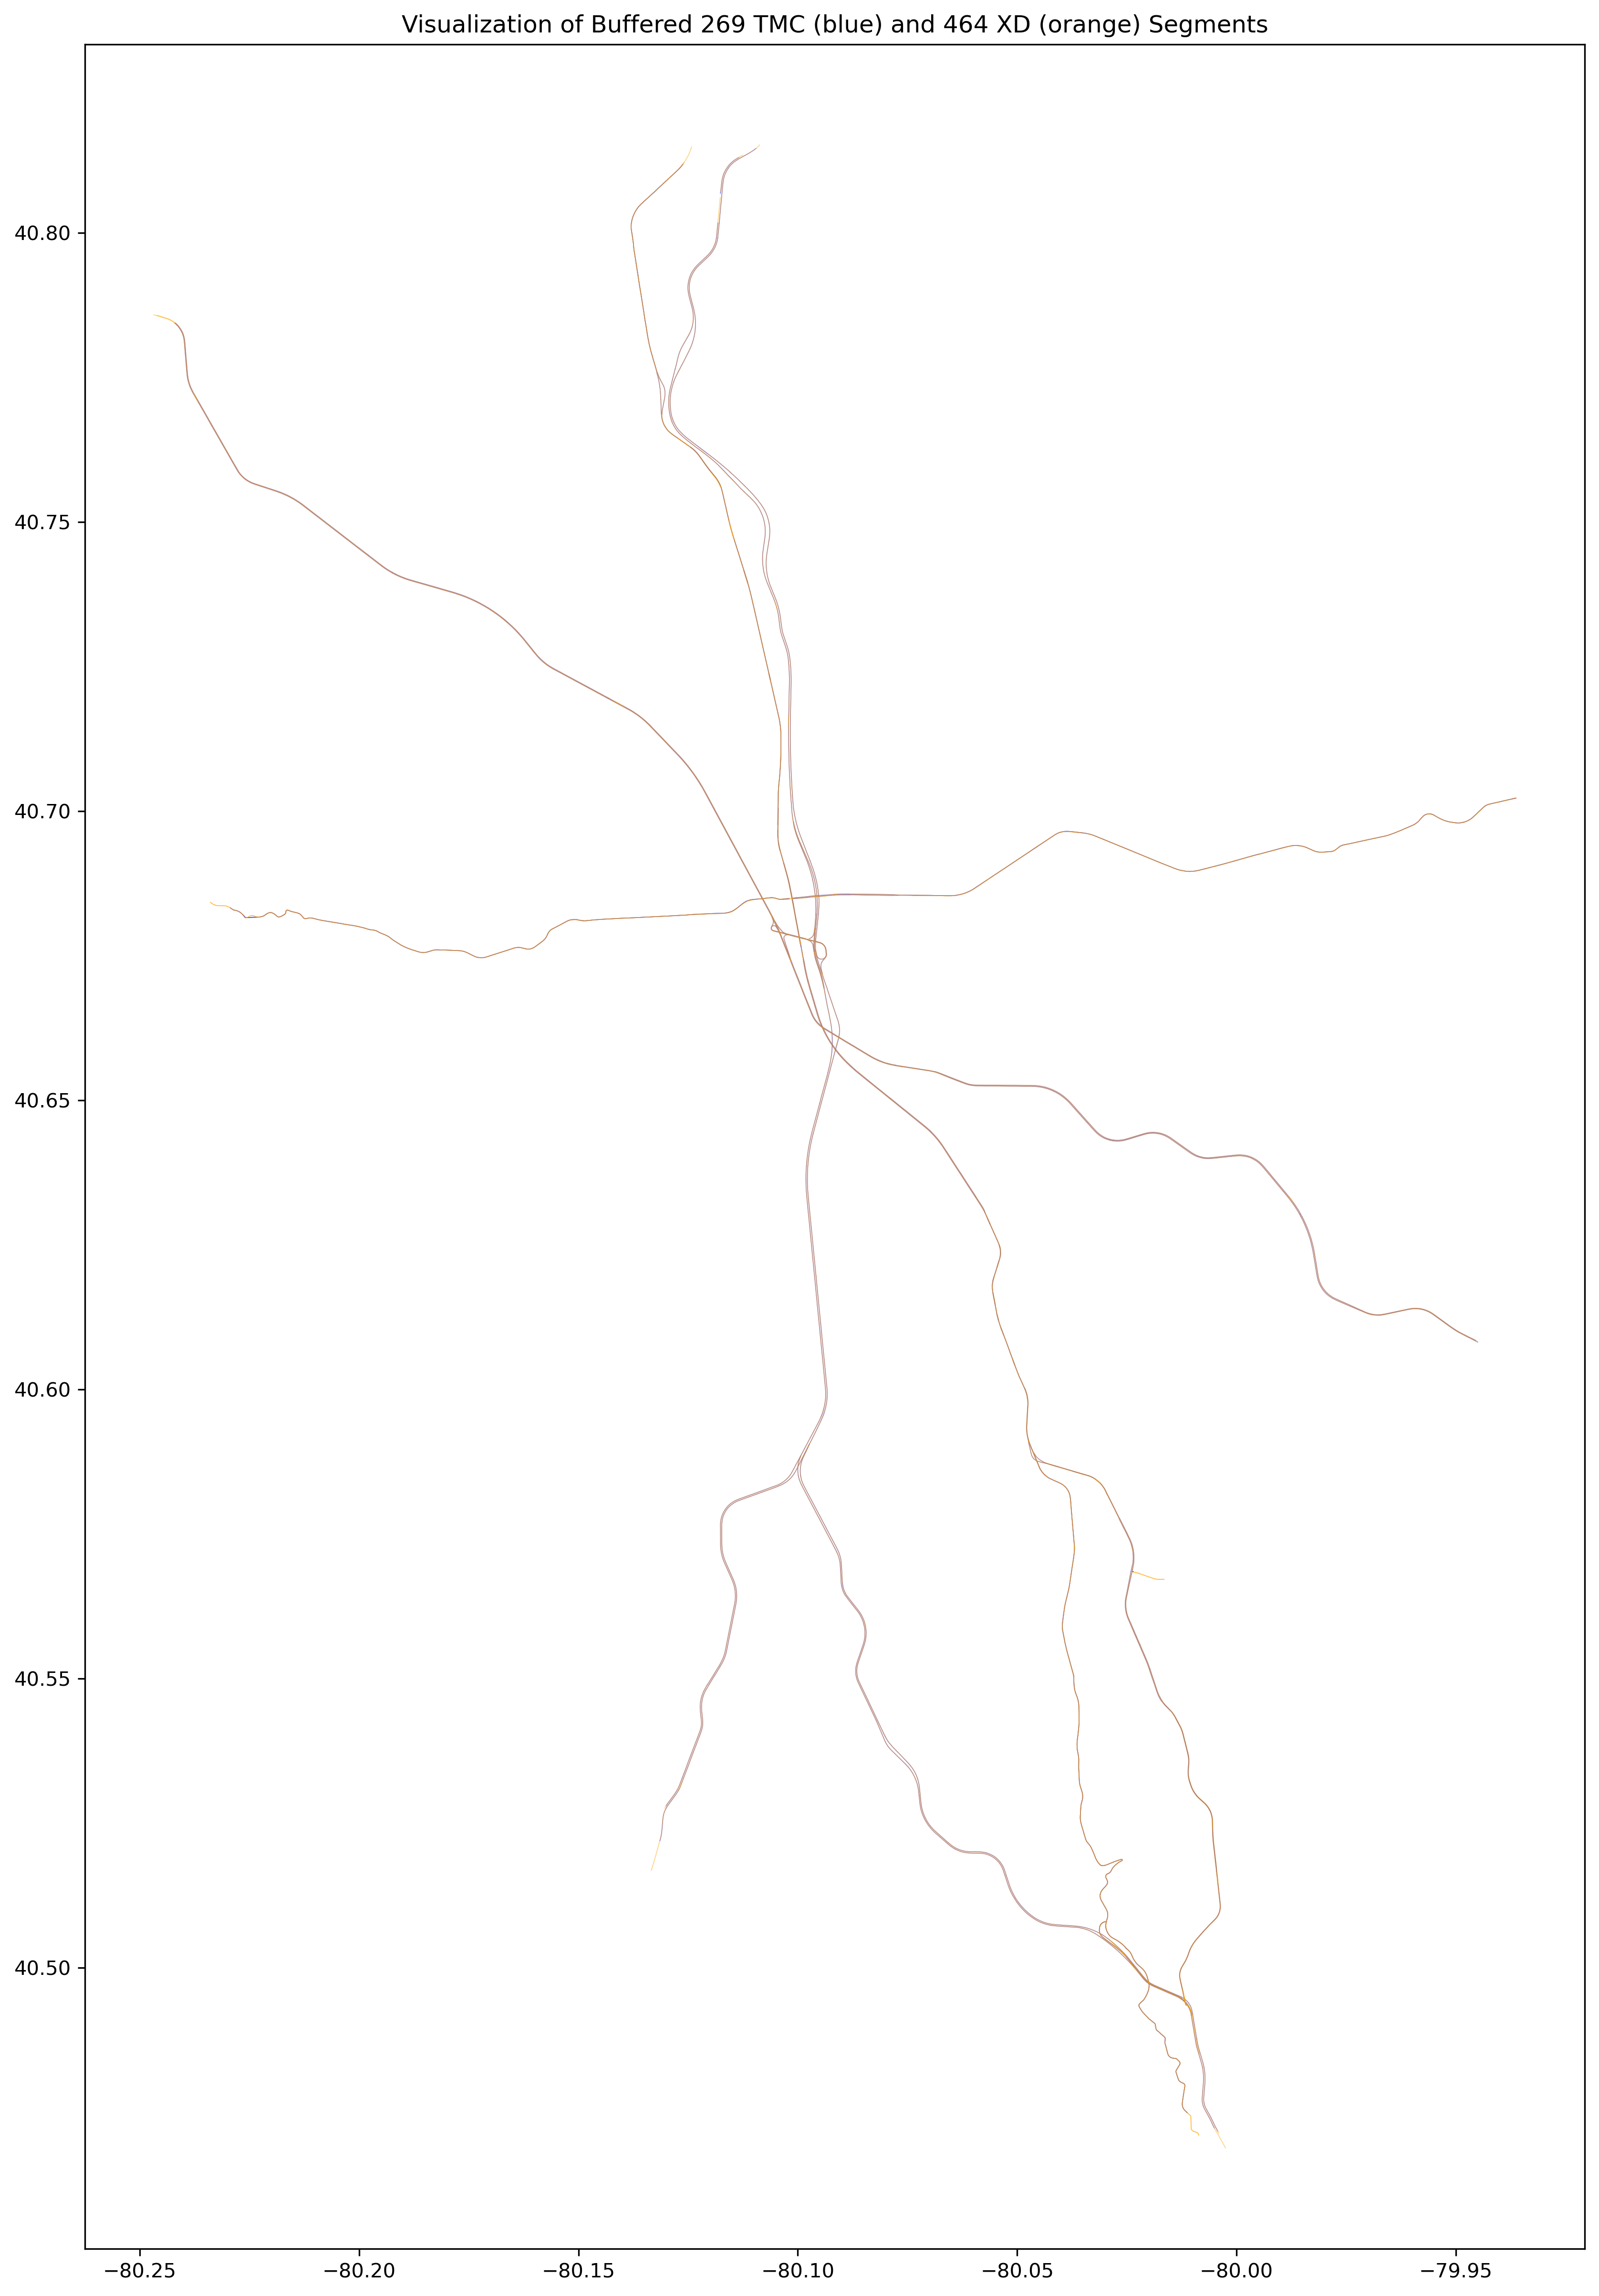

In [37]:
# Visualization of Matched 269 TMC (blue) and 464 XD (yellow) Segments (Buffered with radius 10)
fig, ax = plt.subplots(1,figsize=(30,20), dpi=300)
ax.set_title("Visualization of Buffered 269 TMC (blue) and 464 XD (orange) Segments")
gdf_tmc_cranberry_polygon[gdf_tmc_cranberry_polygon.tmc.isin(set(final_xd_to_tmc.id_tmc))].plot(ax=ax, color="blue", alpha=0.5)
gdf_xd_cranberry_polygon[gdf_xd_cranberry_polygon.XDSegID.astype(int).isin(set(final_xd_to_tmc.id_xd))].plot(ax=ax, color="orange", alpha=0.5)
fig.savefig("./viz_final_xd_to_tmc.jpg")